# Plotting

In [23]:
import iris
import iris.coord_categorisation as cat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmocean
import os
import sys
from string import ascii_lowercase
sys.path.append(os.path.abspath("../lib"))
from cubeprep import CubeListExtract as CLE

sys.path.append(os.path.abspath("/home/users/afstyles/VorticityContourAnalysisForNemo/lib/"))
from ContourInt import take_largest_contour

def log_norm(M, norders=3):
    vmax = np.max(np.abs(M))
    log_vmax = np.log10(vmax)
    log_norm = matplotlib.colors.LogNorm(vmax = vmax, vmin=10**(log_vmax - norders))
    
    return log_norm

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def tm(M, axis=0):
    return np.mean(M, axis=axis)

fig_format='png'

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


In [24]:
# data_dir = os.path.abspath("/gws/nopw/j04/aopp/astyles/CANAL_DATA/experiments/OpSmplxNoise/CANAL_TESTING_R4_R4_N100I_SUM/EXP/")
data_dir = os.path.abspath("/gws/nopw/j04/aopp/astyles/CANAL_DATA/experiments/OpSmplxNoise2/IDEALIZED_WG_80km_EXP_80km_FULL/EXP/")
out_dir = os.path.abspath(data_dir + '/OUTPUT.XRtest/')
timeseries_dir = os.path.abspath( data_dir + "/../")
VCAN_dir = os.path.abspath(data_dir + '/OUTPUT_VCAN_without_interp/')

In [25]:
cube_list = iris.load(out_dir + '/*.nc')
# data_list = iris.load(data_dir + '/*grid*.nc')
mask_list = iris.load(data_dir + '/mesh_mask.nc')
timeseries_list = iris.load(timeseries_dir + '/CANAL_grid_timeseries.combined.nc')
transport_list = iris.load(timeseries_dir + '/CANAL_grid_WGtimeseries.combined.nc')

/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global att

In [26]:
# v_cube = CLE(data_list, 'voce')[...,1:-1]
# w_cube = CLE(data_list, 'woce')[...,1:-1]
# rhop_cube = CLE(data_list, 'swsigthet')[...,1:-1]
# temp_cube = CLE(data_list, 'toce')[...,1:-1]
# sal_cube = CLE(data_list, 'soce')[...,1:-1]
# ssh_cube = CLE(data_list, 'ssh')[...,1:-1]
vmask = iris.util.squeeze(CLE(mask_list, 'umask')).data[...,1:-1]
umask = iris.util.squeeze(CLE(mask_list, 'vmask')).data[...,1:-1]
tmask = iris.util.squeeze(CLE(mask_list, 'tmask')).data[...,1:-1]
umaskutil = iris.util.squeeze(CLE(mask_list, 'umaskutil')).data[...,1:-1]
vmaskutil = iris.util.squeeze(CLE(mask_list, 'vmaskutil')).data[...,1:-1]
tmaskutil = iris.util.squeeze(CLE(mask_list, 'tmaskutil')).data[...,1:-1]
e3t = iris.util.squeeze(CLE(mask_list, 'e3t_0')).data[...,1:-1]
e3u = iris.util.squeeze(CLE(mask_list, 'e3u_0')).data[...,1:-1]
e3v = iris.util.squeeze(CLE(mask_list, 'e3v_0')).data[...,1:-1]
depth_1d = iris.util.squeeze(CLE(mask_list,'gdept_1d')).data
lat = iris.util.squeeze(CLE(mask_list,'nav_lat')).data[...,1:-1]
lon = iris.util.squeeze(CLE(mask_list,'nav_lon')).data[...,1:-1]
gdept_0 = iris.util.squeeze(CLE(mask_list,'gdept_0')).data[...,1:-1]
eke_zint_cube = CLE(cube_list, 'eke_zint')[...,1:-1]




# v = np.ma.masked_array(v_cube.data, mask=np.broadcast_to(~np.ma.make_mask(vmask), v_cube.shape))
# rhop = np.ma.masked_array(rhop_cube.data, mask=np.broadcast_to(~np.ma.make_mask(tmask), rhop_cube.shape))

In [27]:
lat_1d = np.mean(lat, axis=-1)
lon_1d = np.mean(lon, axis=-2)

In [28]:
# eke_cube = CLE(cube_list, 'eke_year')[...,1:-1]
# eke_zint_cube = CLE(cube_list, 'eke_zint_year')[...,1:-1]
sf_zint_cube = CLE(cube_list, 'sf_zint')[...,1:-1]
ACC_cube = CLE(cube_list, 'ACC_transport')
WG_cube = CLE(cube_list, 'WG_transport')
# res_ov_cube = CLE(cube_list, 'res_ov')[...,1:-1]
res_ov_depth_cube = CLE(cube_list, 'res_ov_depth')

ts_sal_cube = CLE(timeseries_list, 'mean_salinity')
aux_time = ts_sal_cube.aux_coords[0]
aux_time.rename('aux_time')
cat.add_year(ts_sal_cube, "time", name="year")

ts_acc_cube = CLE(timeseries_list, 'acc_transport')
aux_time = ts_acc_cube.aux_coords[0]
aux_time.rename('aux_time')
cat.add_year(ts_acc_cube, "time", name="year")

ts_tem_cube = CLE(timeseries_list, 'mean_temperature')
aux_time = ts_tem_cube.aux_coords[0]
aux_time.rename('aux_time')
cat.add_year(ts_tem_cube, "time", name="year")

ts_wg_cube = CLE(transport_list, 'WG_transport')
aux_time = ts_acc_cube.aux_coords[0]
aux_time.rename('aux_time')
cat.add_year(ts_wg_cube, "time", name="year")


temp_list = iris.load(out_dir + '/temp_xint.nc')
rhop_list = iris.load(out_dir + '/rhop_xint.nc')
sal_list = iris.load(out_dir + '/sal_xint.nc')
eke_list = iris.load(out_dir + '/eke_xint.nc')
u_list = iris.load(out_dir + '/u_xint.nc')
v_list = iris.load(out_dir + '/v_xint.nc')

# temp_range1_cube = CLE(cube_list, 'temp_xint_range1')
# temp_range2_cube = CLE(cube_list, 'temp_xint_range2')
# temp_fullwidth_cube = CLE(cube_list, 'temp_xint_fullwidth')
# sal_range1_cube = CLE(cube_list, 'sal_xint_range1')
# sal_range2_cube = CLE(cube_list, 'sal_xint_range2')
# sal_fullwidth_cube = CLE(cube_list, 'sal_xint_fullwidth')
# rhop_range1_cube = CLE(cube_list, 'rhop_xint_range1')
# rhop_range2_cube = CLE(cube_list, 'rhop_xint_range2')
# rhop_fullwidth_cube = CLE(cube_list, 'rhop_xint_fullwidth')
u_range1_cube = CLE(cube_list, 'u_xint_range1')
u_range2_cube = CLE(cube_list, 'u_xint_range2')
u_fullwidth_cube = CLE(cube_list, 'u_xint_fullwidth')

# WG_transport = np.mean(WG_cube.data)
WG_transport = np.max(np.mean(sf_zint_cube.data,axis=0)*(lat < 0))
ACC_transport = np.mean(ACC_cube.data)
depth_array = np.sum(e3t * tmask, axis=-3)
depth_array = np.ma.masked_less_equal(depth_array, 0)



/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global att

Variable name not found:  u_xint_range1
Variable name not found:  u_xint_range2


/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global attribute 'units': 'units' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/home/users/afstyles/.conda/envs/jupyter_general/lib/python3.9/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1957: UserWarning: Skipping global att

# Bathymetry

<ipython-input-29-eb60fc864479>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon_1d, lat_1d, depth_array, cmap=cmocean.cm.deep )


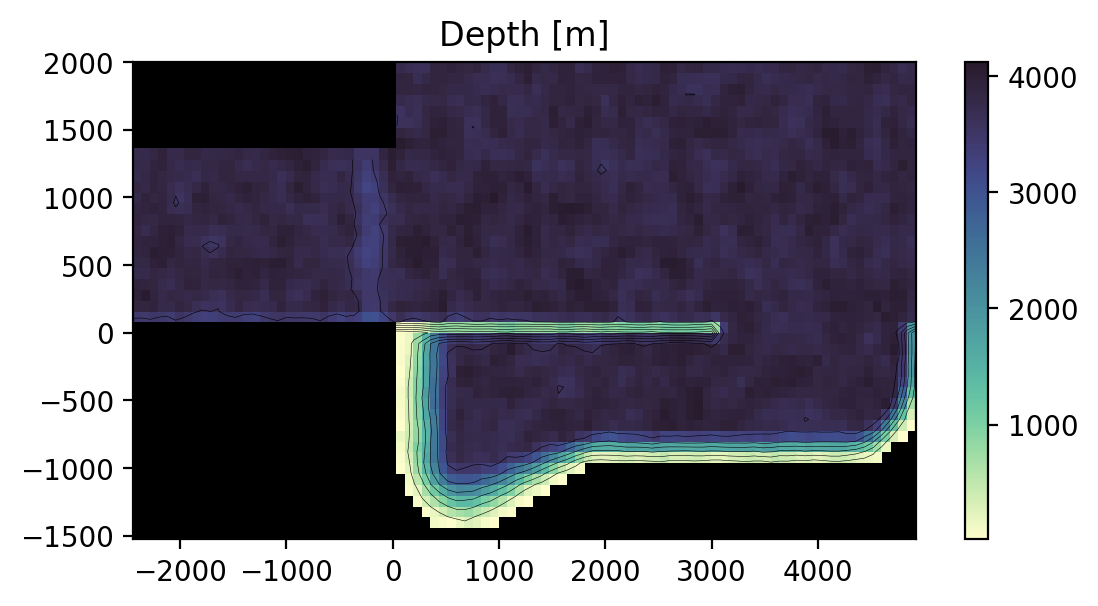

In [29]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Depth [m]")
plt.pcolormesh(lon_1d, lat_1d, depth_array, cmap=cmocean.cm.deep )
plt.colorbar()
CS = plt.contour(lon_1d, lat_1d, depth_array, levels=7, colors='k', linewidths=0.2 )
plt.gca().set_facecolor('k')
plt.savefig(out_dir + '/depth.png', bbox_inches='tight')




# Horizontal Stream Function

<ipython-input-30-bf439603c1d7>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lon_1d, lat_1d, np.mean(sf_zint_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm = matplotlib.colors.TwoSlopeNorm(vcenter=0) )


WG transport =  11.9
ACC transport =  151.026


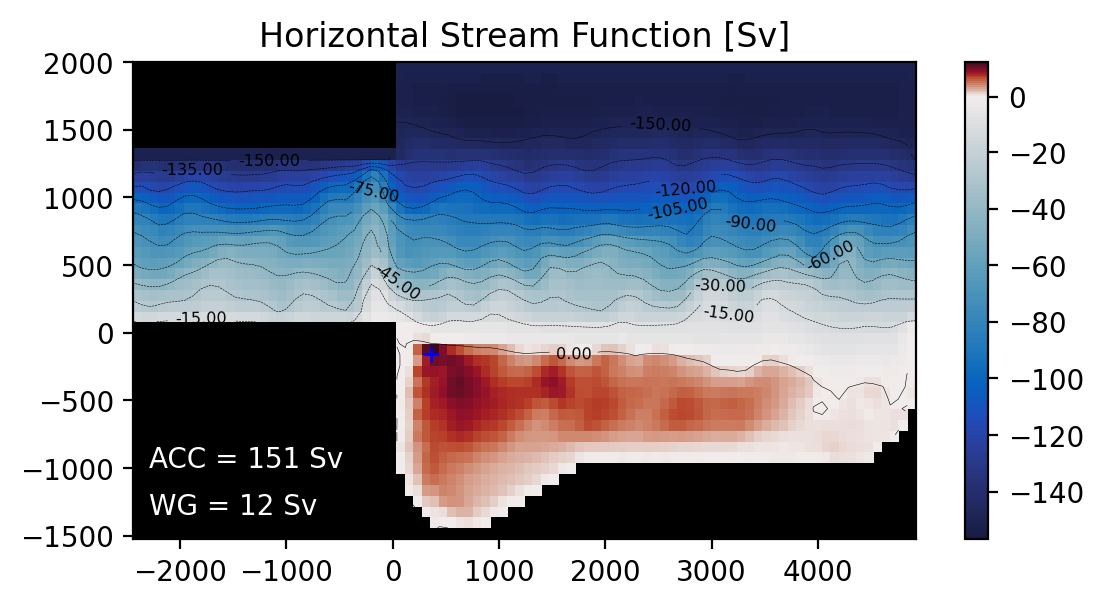

In [30]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Horizontal Stream Function [Sv]")
plt.pcolormesh(lon_1d, lat_1d, np.mean(sf_zint_cube.data[:,:,:],axis=0), cmap=cmocean.cm.balance, norm = matplotlib.colors.TwoSlopeNorm(vcenter=0) )
plt.colorbar()
# plt.gca().set_aspect(1)
CS = plt.contour(lon_1d, lat_1d, np.mean(sf_zint_cube.data[:,:,:],axis=0), norm = matplotlib.colors.TwoSlopeNorm(vcenter=0), levels=15, colors='k', linewidths=0.2 )
plt.gca().set_facecolor('k')
def fmt(x):
        s = f"{x:.2f}"
        if s.endswith("0"):
            s = f"{x:.2f}"
        return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

plt.clabel(CS, CS.levels, inline=True, fontsize='xx-small', fmt=fmt)

#Place cross where maximum lies
(ij_max, ii_max) = np.where(np.mean(sf_zint_cube.data[:,:,:],axis=0)==WG_transport)

plt.plot(lon_1d[ii_max],lat_1d[ij_max], 'b+')

plt.text(0.02 ,0.15,fr"ACC = {np.round(ACC_transport):.0f} Sv", transform=plt.gca().transAxes, color='white')
plt.text(0.02 ,0.05,fr"WG = {np.round(WG_transport):.0f} Sv", transform=plt.gca().transAxes, color='white')
plt.savefig(out_dir + f'/sf_zint.{fig_format}', bbox_inches='tight')

print(f"WG transport =  {np.round(WG_transport, decimals=3)}")
print(f"ACC transport =  {np.round(ACC_transport, decimals=3)}")

# WG transport (EXP)

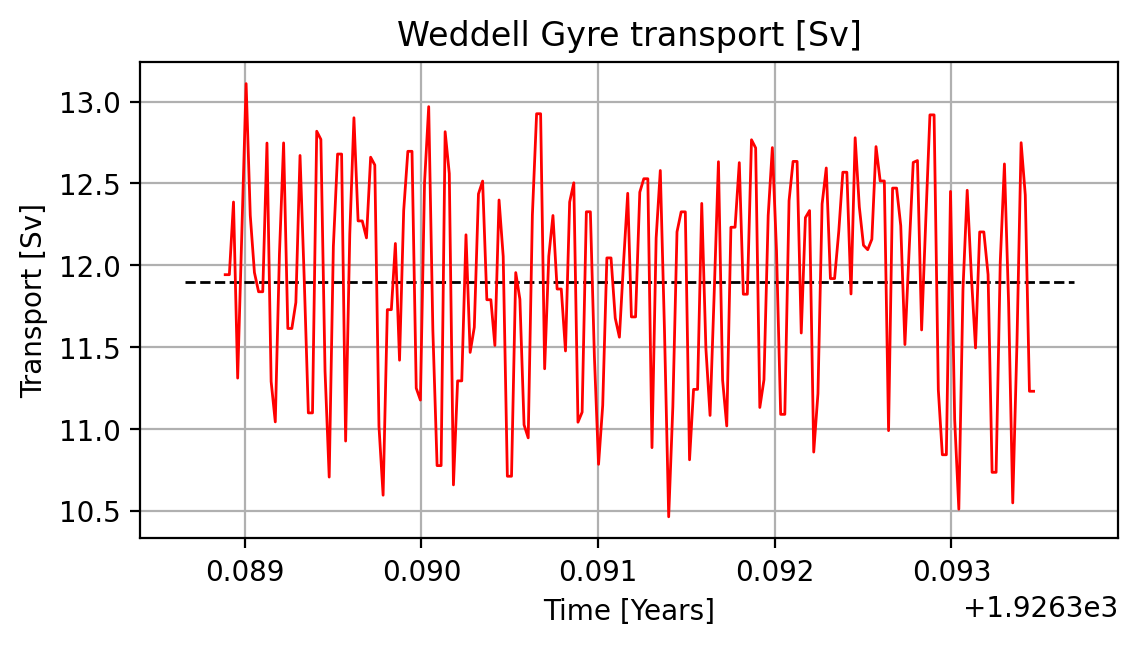

In [31]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Weddell Gyre transport [Sv]")
time_points = (WG_cube.coord("time_counter").points + 1900*365*24*60*60)/(360*24*60*60)
plt.grid(True)
plt.plot(time_points, WG_cube.data, color='red', lw=1)
plt.ylabel(r"Transport [Sv]")
plt.xlabel(r"Time [Years]")
plt.hlines(WG_transport, plt.xlim()[0], plt.xlim()[1], color='black', linestyle='dashed', lw=1)
plt.savefig(out_dir + f'/WG_transport.{fig_format}', bbox_inches='tight')

# ACC transport (EXP)

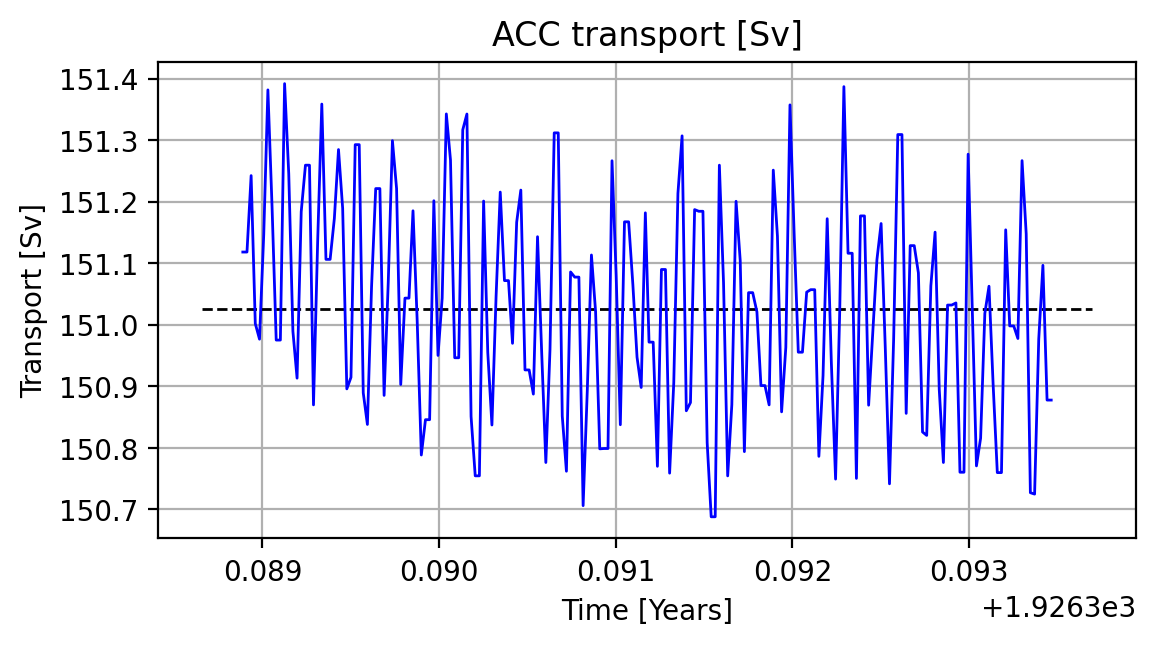

In [32]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"ACC transport [Sv]")
plt.grid(True)
time_points = (ACC_cube.coord("time_counter").points + 1900*365*24*60*60)/(360*24*60*60)
plt.plot(time_points, ACC_cube.data, color='blue', lw=1)
plt.ylabel(r"Transport [Sv]")
plt.xlabel(r"Time [Years]")
plt.hlines(ACC_transport, plt.xlim()[0], plt.xlim()[1], color='black', linestyle='dashed', lw=1)
plt.savefig(out_dir + f'/ACC_transport.{fig_format}', bbox_inches='tight')

# Isotherms

In [33]:
nfig = len(temp_list)
nrow = int(np.ceil(nfig/3))
ncol = 3

cbarlim_max = 10
cbarlim_min = 0.

<ipython-input-34-83e57b13fe56>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.thermal, vmin=cbarlim_min, vmax=cbarlim_max)
<ipython-input-34-83e57b13fe56>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.thermal, vmin=cbarlim_min, vmax=cbarlim_max)
<ipython-input-34-83e57b13fe56>:11: MatplotlibDeprecationWarni

NameError: name 'temp_cube' is not defined

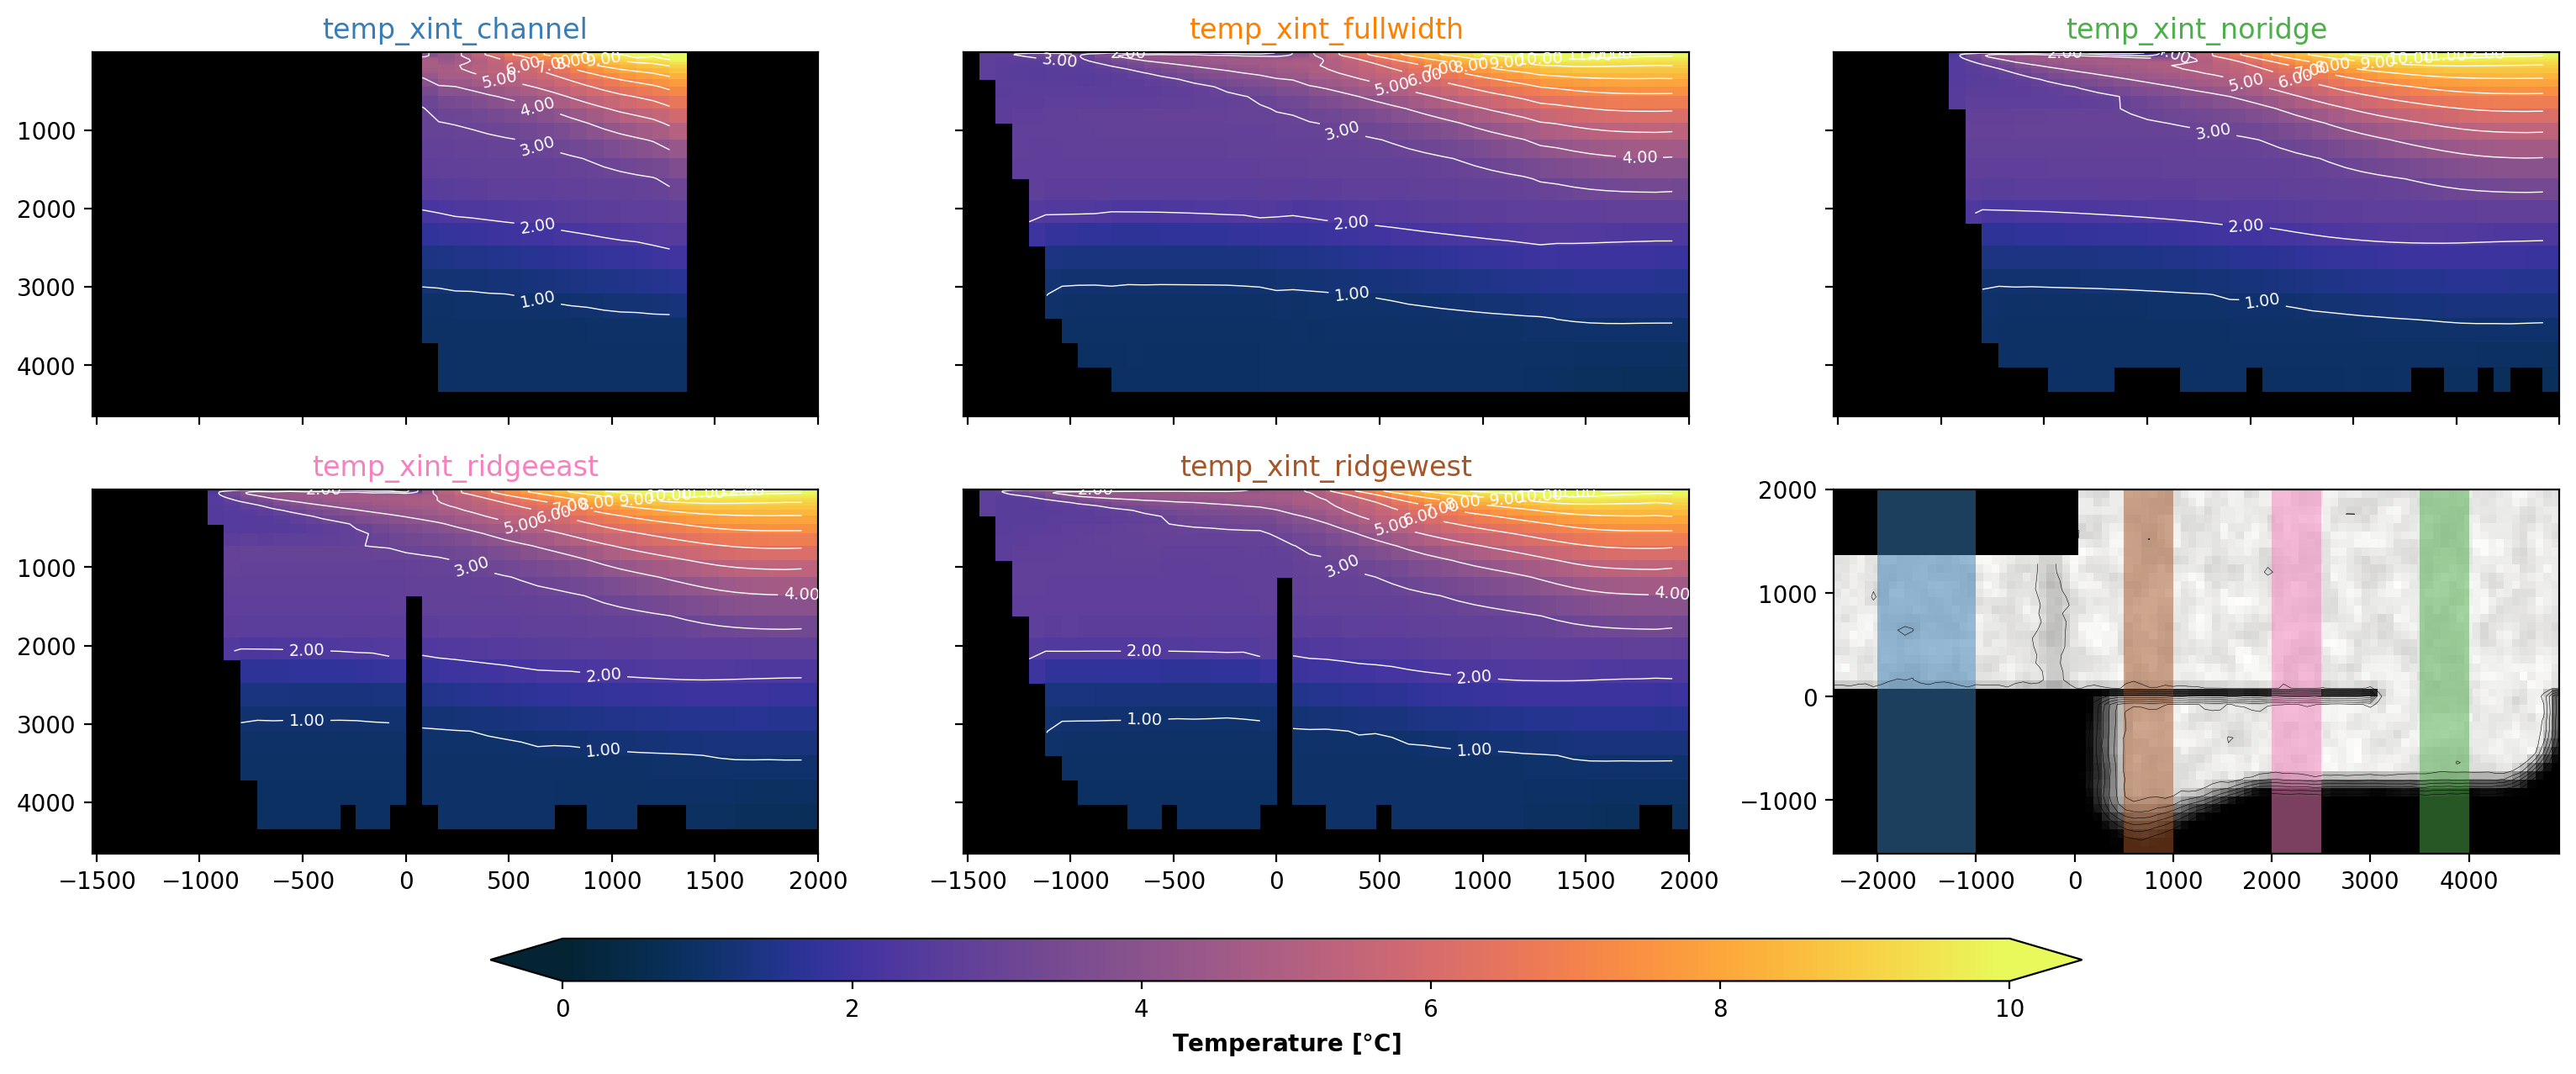

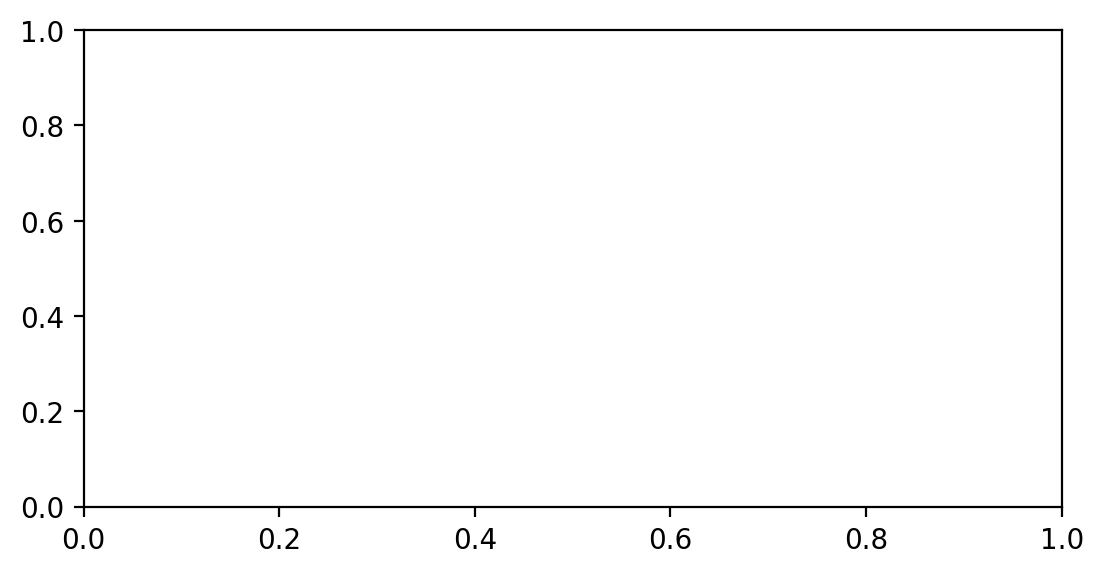

In [34]:
fig,ax = plt.subplots(nrow, ncol, figsize=(2*ncol*3.1554, nrow*3.1554), dpi=200)
var_names = [cube.var_name for cube in temp_list]
var_names.sort()

for i in range(nfig):
    irow = int(np.floor(i/ncol)) 
    icol = i - irow * ncol

    cube = CLE(temp_list, var_names[i])
    array = np.mean(cube.data, axis=0)
    cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.thermal, vmin=cbarlim_min, vmax=cbarlim_max)
    CS = ax[irow, icol].contour(lat_1d, depth_1d, array, colors='white', linewidths=0.5, levels=11)
    ax[irow, icol].clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
    ax[irow, icol].set_facecolor('k')
    ax[irow, icol].set_title(cube.var_name, color=CB_color_cycle[i])
    ax[irow, icol].invert_yaxis()
    
    if icol != 0 : ax[irow, icol].set_yticklabels([])
    if irow != nrow-1 : ax[irow, icol].set_xticklabels([])
        
if nrow*ncol > nfig:
    irow = int(np.floor((nfig)/ncol))
    icol = nfig - irow * ncol
    
    ax[irow, icol].pcolormesh( lon_1d, lat_1d, depth_array, cmap=cmocean.cm.gray )
    ax[irow, icol].contour(lon_1d, lat_1d, depth_array, levels=7, colors='k', linewidths=0.2 )
    ax[irow, icol].set_facecolor('k')
    
    i=0
    for i in range(nfig):
        cube = CLE(temp_list, var_names[i])
        att_dict = cube.attributes
        xmin, xmax = int(att_dict['xmin']), int(att_dict['xmax'])
        ax[irow,icol].fill_between([xmin,xmax], lat_1d.min(), lat_1d.max(), alpha=0.5, color=CB_color_cycle[i], ec=None)
        
        i=i+1
    
ax_bounds = ax[-1,0].get_position().bounds
cbar_ax = fig.add_axes([0.25, ax_bounds[1] -0.12 , 0.5, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"Temperature [$\degree$C]", fontweight='bold')     

    
fig.savefig(out_dir + f'/temp_xint.{fig_format}', bbox_inches='tight')      


fig, ax = plt.subplots( figsize=(2*3.1554, 3.1554), dpi=200)
temp_surf_array = np.mean(temp_cube.data[:,0,:,:], axis=0)
temp_surf_array = np.ma.masked_array(temp_surf_array, mask=~np.ma.make_mask(tmaskutil))
cax = ax.pcolormesh(lon_1d, lat_1d, temp_surf_array, cmap=cmocean.cm.thermal, vmin=cbarlim_min, vmax=cbarlim_max)
ax.set_facecolor('k')
ax_bounds = ax.get_position().bounds
cbar_ax = fig.add_axes([0.1, ax_bounds[1] -0.2 , 0.8, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"Surface temperature [$\degree$C]", fontweight='bold')   

fig.savefig(out_dir + f'/sst.{fig_format}', bbox_inches='tight')

# Isohalines

In [35]:
nfig = len(sal_list)
nrow = int(np.ceil(nfig/3))
ncol = 3

cbarlim_max = 36
vmid = 35
cbarlim_min = 34

<ipython-input-36-c8e64740759d>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vmin=cbarlim_min, vcenter=vmid, vmax=cbarlim_max))
<ipython-input-36-c8e64740759d>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vmin=cbarli

NameError: name 'sal_cube' is not defined

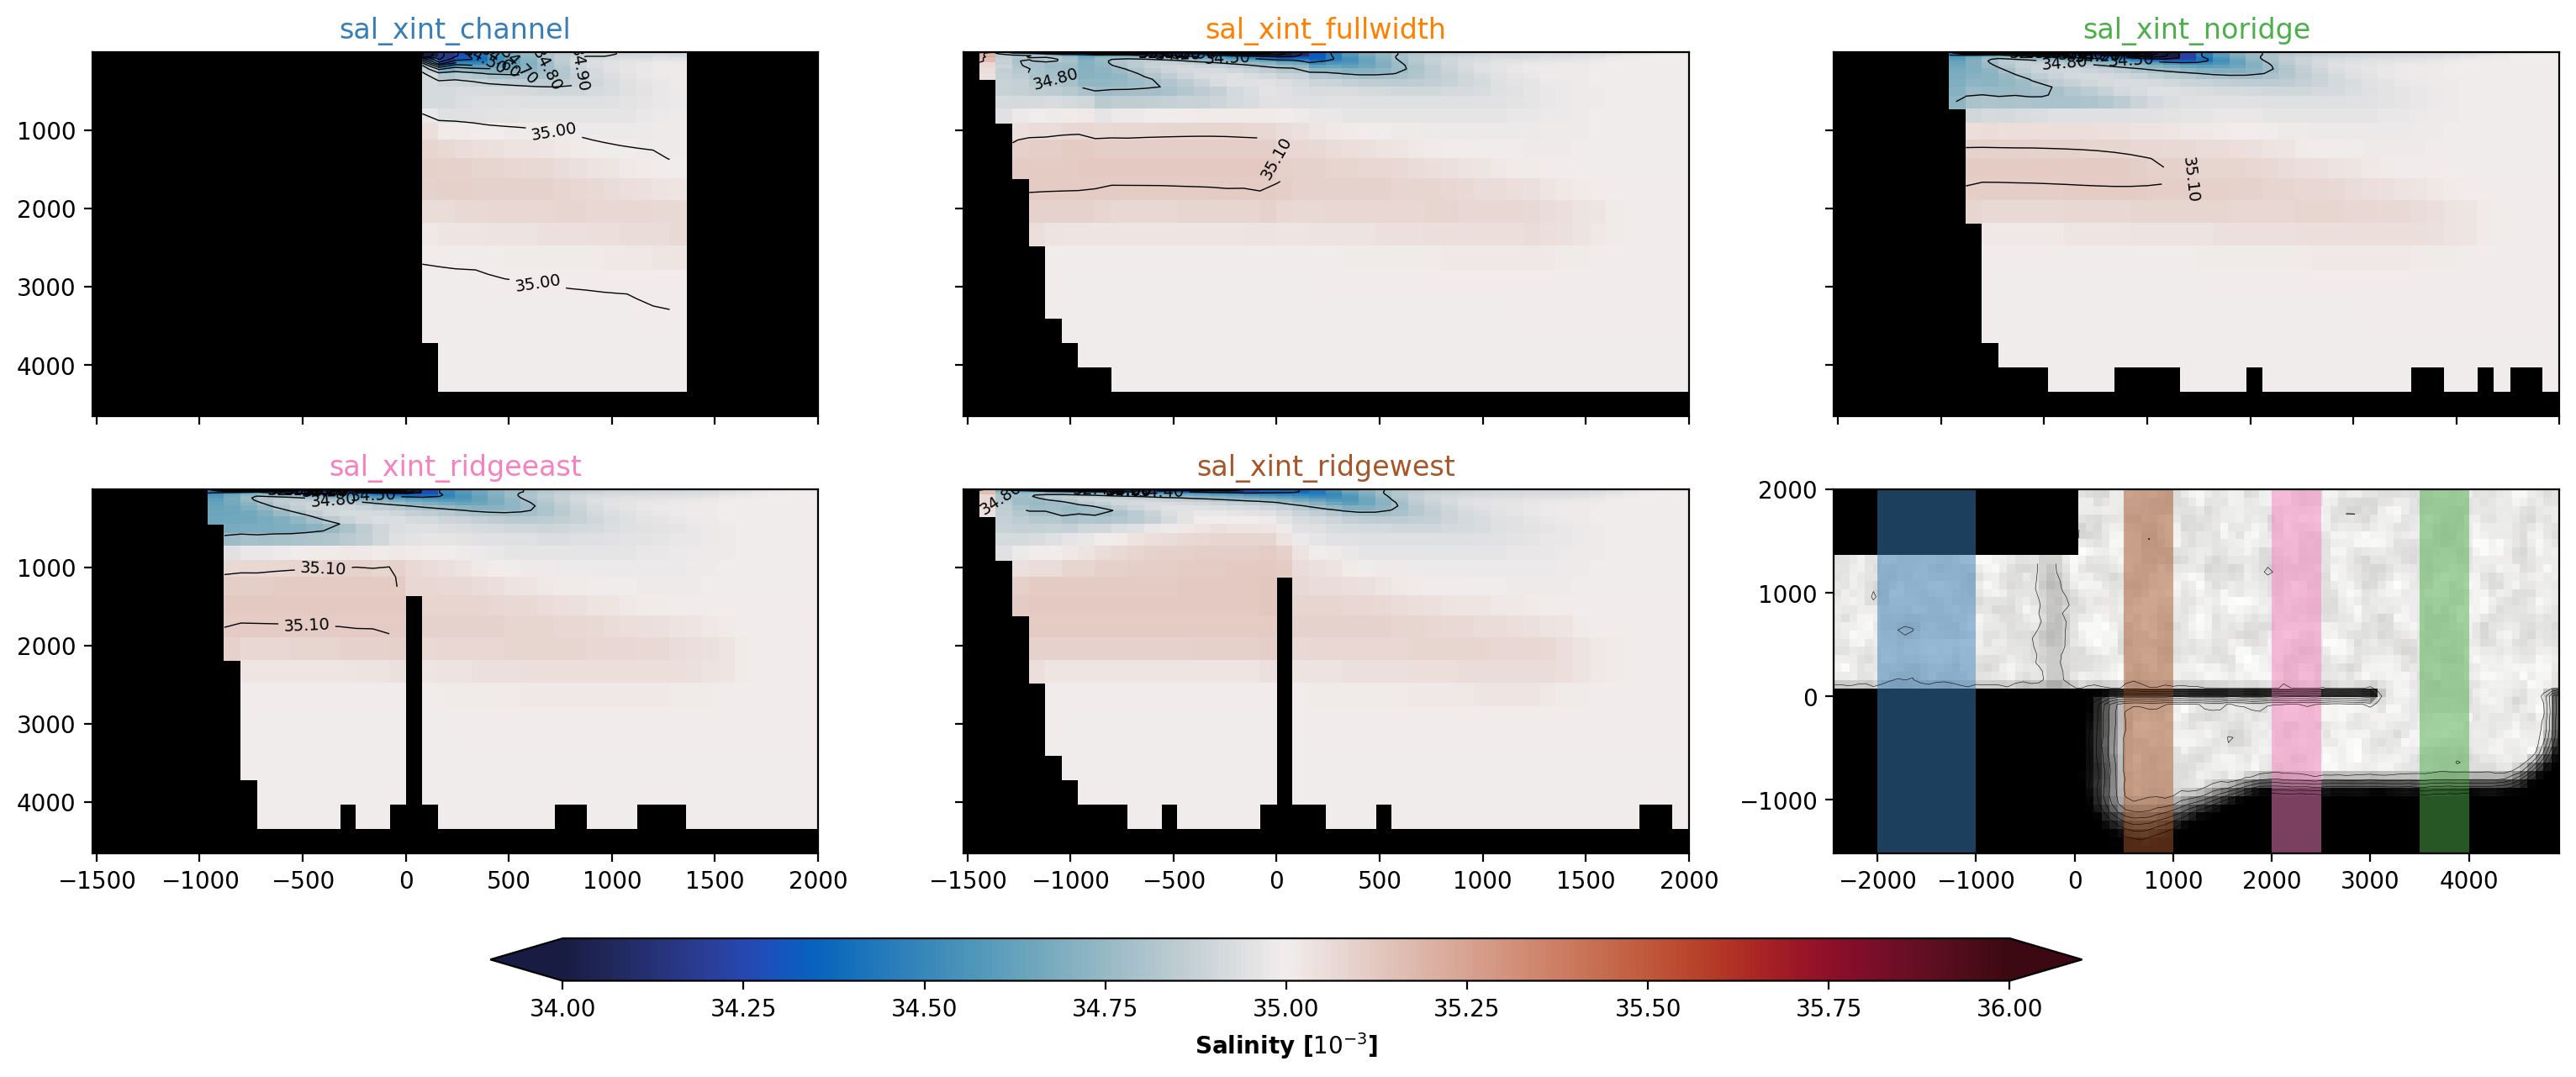

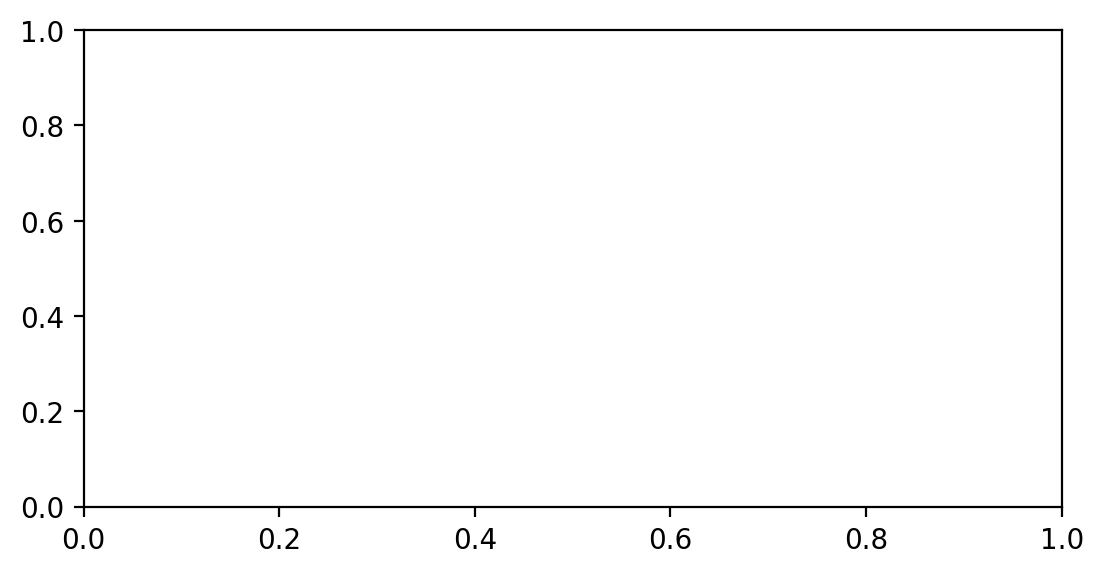

In [36]:
fig,ax = plt.subplots(nrow, ncol, figsize=(2*ncol*3.1554, nrow*3.1554), dpi=200)
var_names = [cube.var_name for cube in sal_list]
var_names.sort()


for i in range(nfig):
    irow = int(np.floor(i/ncol)) 
    icol = i - irow * ncol

    cube = CLE(sal_list, var_names[i])
    array = np.mean(cube.data, axis=0)
    cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vmin=cbarlim_min, vcenter=vmid, vmax=cbarlim_max))
    CS = ax[irow, icol].contour(lat_1d, depth_1d, array, colors='k', linewidths=0.5, levels=11)
    ax[irow, icol].clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
    ax[irow, icol].set_facecolor('k')
    ax[irow, icol].set_title(cube.var_name, color=CB_color_cycle[i])
    ax[irow, icol].invert_yaxis()
    
    if icol != 0 : ax[irow, icol].set_yticklabels([])
    if irow != nrow-1 : ax[irow, icol].set_xticklabels([])
        
if nrow*ncol > nfig:
    irow = int(np.floor((nfig)/ncol))
    icol = nfig - irow * ncol
    
    ax[irow, icol].pcolormesh( lon_1d, lat_1d, depth_array, cmap=cmocean.cm.gray )
    ax[irow, icol].contour(lon_1d, lat_1d, depth_array, levels=7, colors='k', linewidths=0.2 )
    ax[irow, icol].set_facecolor('k')
    
    i=0
    for i in range(nfig):
        cube = CLE(sal_list, var_names[i])
        att_dict = cube.attributes
        xmin, xmax = int(att_dict['xmin']), int(att_dict['xmax'])
        ax[irow,icol].fill_between([xmin,xmax], lat_1d.min(), lat_1d.max(), alpha=0.5, color=CB_color_cycle[i], ec=None)
        
        i=i+1
    

ax_bounds = ax[-1,0].get_position().bounds
cbar_ax = fig.add_axes([0.25, ax_bounds[1] -0.12 , 0.5, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"Salinity [$10^{-3}$]", fontweight='bold')     
    
fig.savefig(out_dir + f'/sal_xint.{fig_format}', bbox_inches='tight')      

fig, ax = plt.subplots( figsize=(2*3.1554, 3.1554), dpi=200)
sal_surf_array = np.mean(sal_cube.data[:,0,:,:], axis=0)
sal_surf_array = np.ma.masked_array(sal_surf_array, mask=~np.ma.make_mask(tmaskutil))
cax = ax.pcolormesh(lon_1d, lat_1d, sal_surf_array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vmin=cbarlim_min, vcenter=vmid, vmax=cbarlim_max))
ax.set_facecolor('k')
ax_bounds = ax.get_position().bounds
cbar_ax = fig.add_axes([0.1, ax_bounds[1] -0.2 , 0.8, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"Surface salinity [$10^{-3}$]", fontweight='bold')   

fig.savefig(out_dir + f'/sss.{fig_format}', bbox_inches='tight')

# Isopycnals

In [37]:
nfig = len(rhop_list)
nrow = int(np.ceil(nfig/3))
ncol = 3

cbarlim_max = 28.5
cbarlim_min = 26

<ipython-input-38-8754cecc0f41>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.dense, vmin=cbarlim_min, vmax=cbarlim_max)
<ipython-input-38-8754cecc0f41>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.dense, vmin=cbarlim_min, vmax=cbarlim_max)
<ipython-input-38-8754cecc0f41>:13: MatplotlibDeprecationWarning: 

NameError: name 'rhop_cube' is not defined

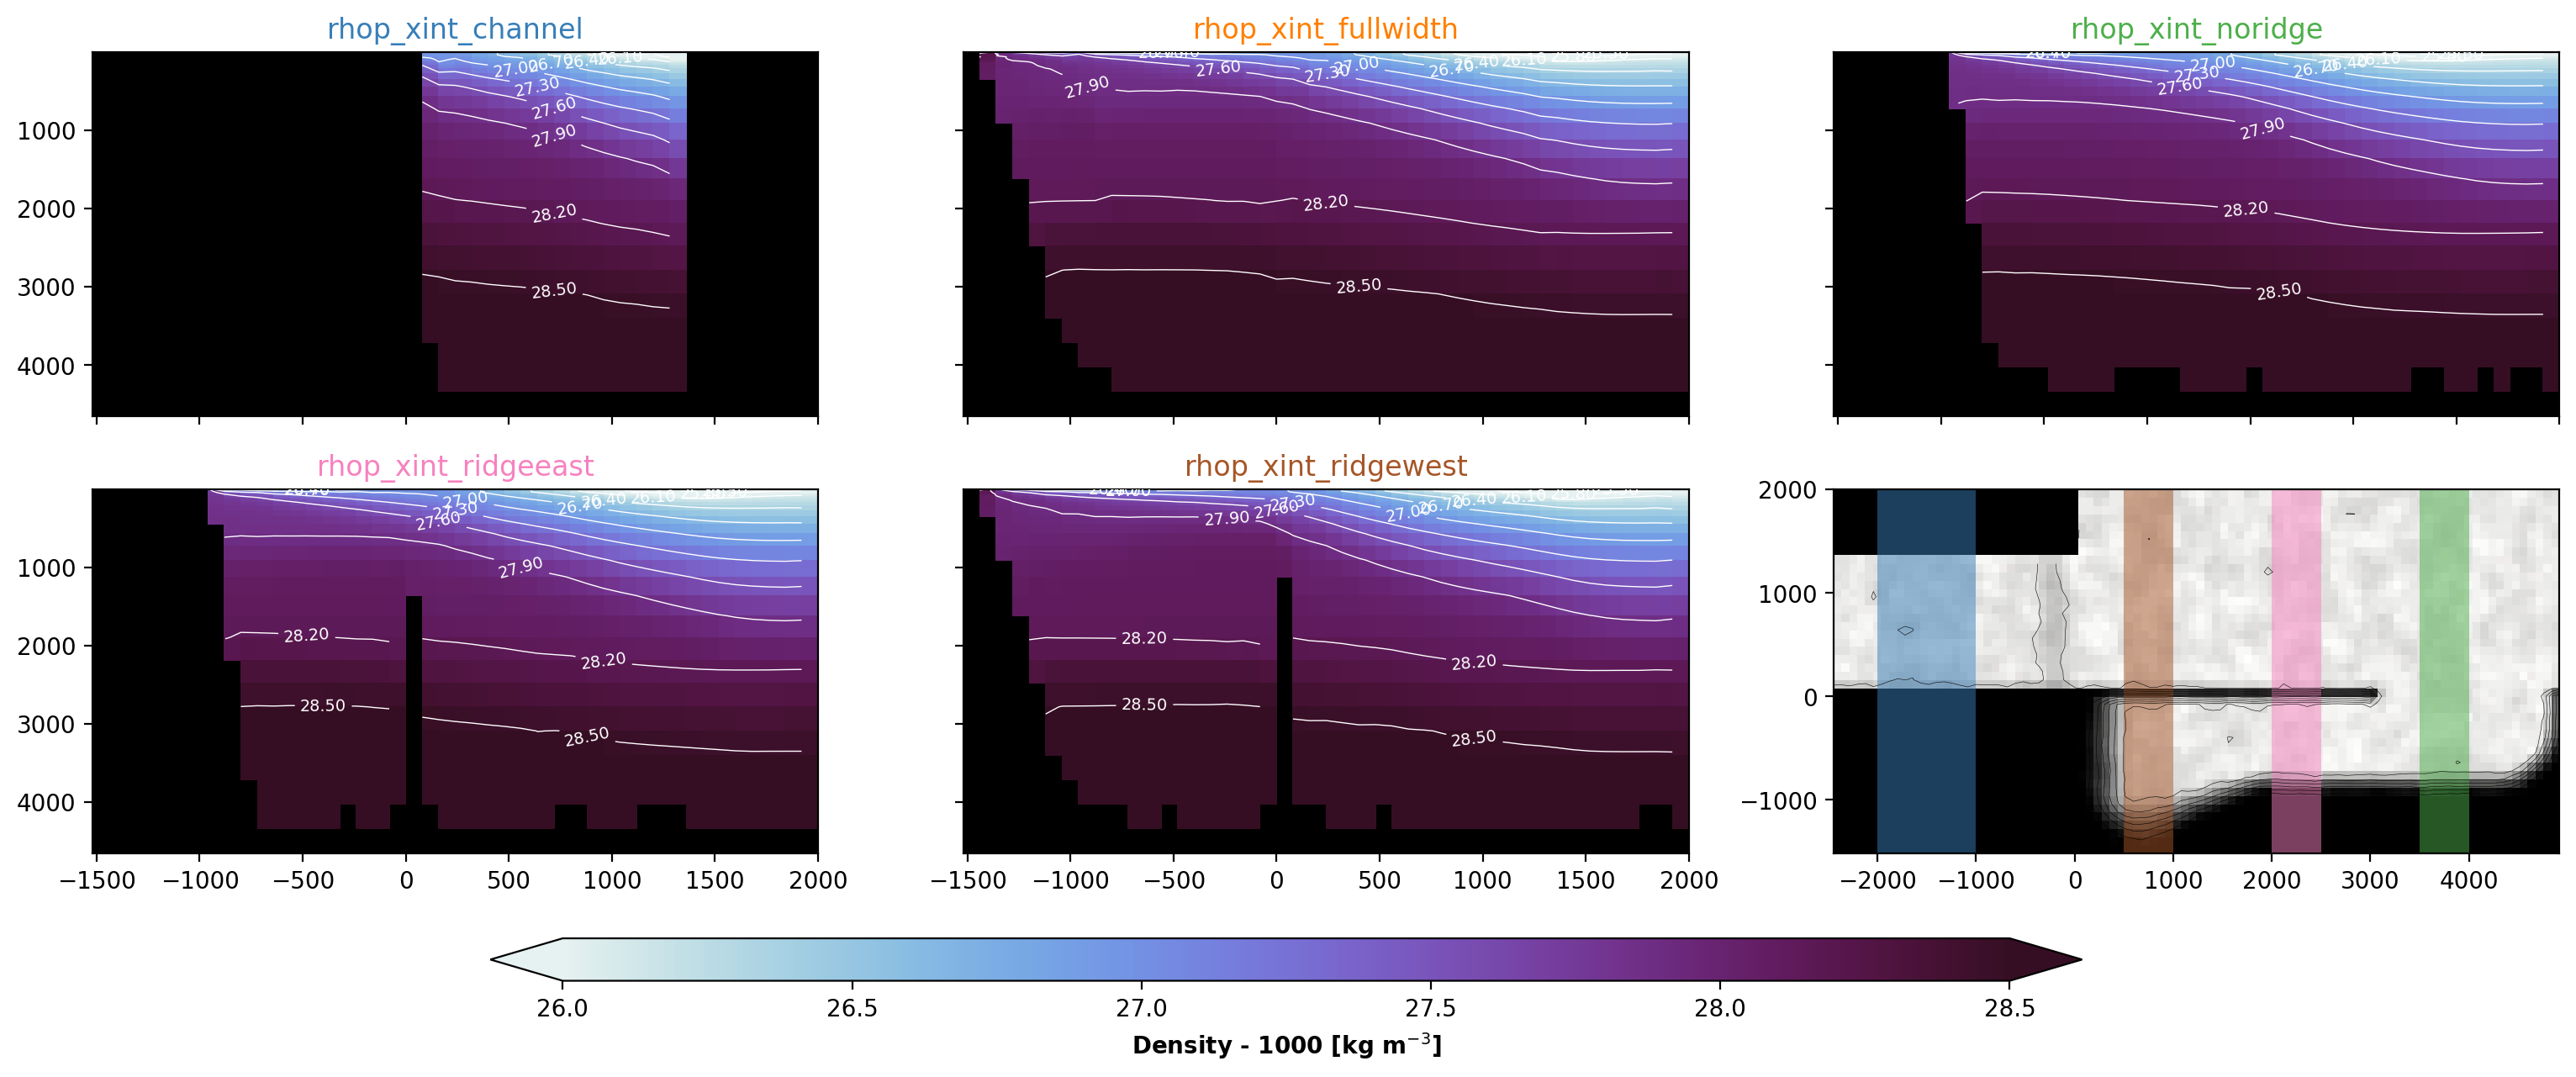

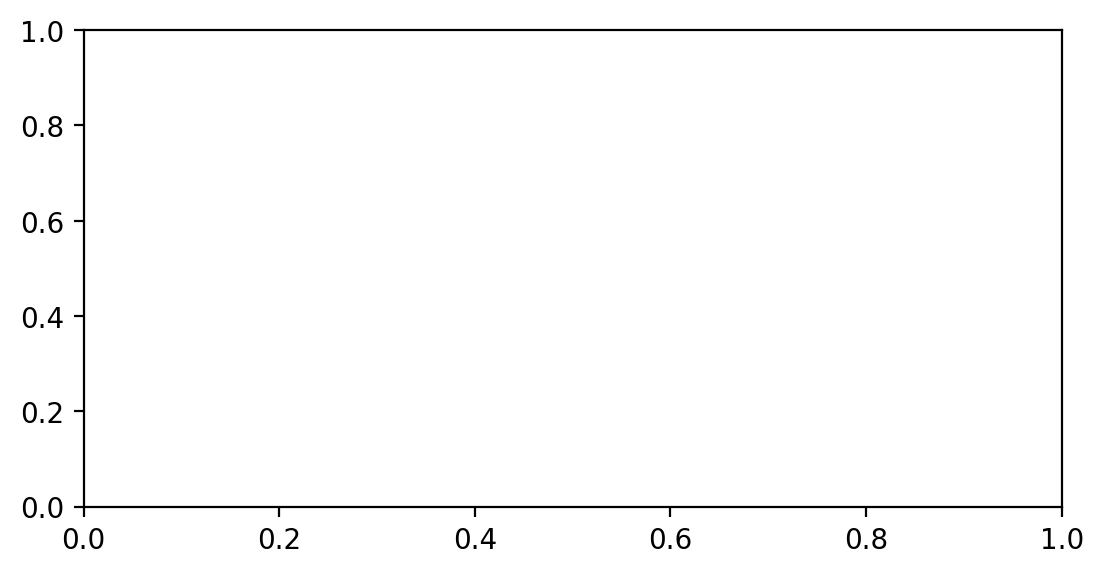

In [38]:
fig,ax = plt.subplots(nrow, ncol, figsize=(2*ncol*3.1554, nrow*3.1554), dpi=200)
var_names = [cube.var_name for cube in rhop_list]
var_names.sort()



for i in range(nfig):
    irow = int(np.floor(i/ncol)) 
    icol = i - irow * ncol

    cube = CLE(rhop_list, var_names[i])
    array = np.mean(cube.data, axis=0) -1000
    cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.dense, vmin=cbarlim_min, vmax=cbarlim_max)
    CS = ax[irow, icol].contour(lat_1d, depth_1d, array, colors='white', linewidths=0.5, levels=11)
    ax[irow, icol].clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
    ax[irow, icol].set_facecolor('k')
    ax[irow, icol].set_title(cube.var_name, color=CB_color_cycle[i])
    ax[irow, icol].invert_yaxis()
    
    if icol != 0 : ax[irow, icol].set_yticklabels([])
    if irow != nrow-1 : ax[irow, icol].set_xticklabels([])
        
if nrow*ncol > nfig:
    irow = int(np.floor((nfig)/ncol))
    icol = nfig - irow * ncol
    
    ax[irow, icol].pcolormesh( lon_1d, lat_1d, depth_array, cmap=cmocean.cm.gray )
    ax[irow, icol].contour(lon_1d, lat_1d, depth_array, levels=7, colors='k', linewidths=0.2 )
    ax[irow, icol].set_facecolor('k')
    
    i=0
    for i in range(nfig):
        cube = CLE(rhop_list, var_names[i])
        att_dict = cube.attributes
        xmin, xmax = int(att_dict['xmin']), int(att_dict['xmax'])
        ax[irow,icol].fill_between([xmin,xmax], lat_1d.min(), lat_1d.max(), alpha=0.5, color=CB_color_cycle[i], ec=None)
        
        i=i+1
    
ax_bounds = ax[-1,0].get_position().bounds
cbar_ax = fig.add_axes([0.25, ax_bounds[1] -0.12 , 0.5, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"Density - 1000 [kg m$^{-3}$]", fontweight='bold')     


fig.savefig(out_dir + f'/rhop_xint.{fig_format}', bbox_inches='tight')   


fig, ax = plt.subplots( figsize=(2*3.1554, 3.1554), dpi=200)
rhop_surf_array = np.mean(rhop_cube.data[:,0,:,:], axis=0) - 1000
rhop_surf_array = np.ma.masked_array(rhop_surf_array, mask=~np.ma.make_mask(tmaskutil))
cax = ax.pcolormesh(lon_1d, lat_1d, rhop_surf_array, cmap=cmocean.cm.dense, vmin=cbarlim_min, vmax=cbarlim_max)
ax.set_facecolor('k')
ax_bounds = ax.get_position().bounds
cbar_ax = fig.add_axes([0.1, ax_bounds[1] -0.2 , 0.8, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"Surface density - 1000 [kg m$^{-3}$]", fontweight='bold')   

fig.savefig(out_dir + f'/ssrhop.{fig_format}', bbox_inches='tight')

In [ ]:
plt.figure(dpi=200)
print(rhop_list)

diff_cube = CLE(rhop_list, 'rhop_xint_ridgeeast') - CLE(rhop_list, 'rhop_xint_ridgewest')
tm_cube = diff_cube.collapsed("time_counter", iris.analysis.MEAN)

plt.gca().invert_yaxis()
plt.gca().set_facecolor('k')
plt.pcolormesh(lat_1d, depth_1d, tm_cube.data, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0))


# Overturning (density space)

In [ ]:
rhop_depth_cube = CLE(cube_list , 'rhop_depth')


ip = 5
print(rhop_depth_cube.coord("Density_level").points[ip])
plt.figure(dpi=200)
plt.pcolormesh( rhop_depth_cube.data.mean(axis=0)[ip,:,:] , cmap=cmocean.cm.deep)
plt.colorbar()
plt.gca().set_facecolor('k')

In [ ]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Residual overturning stream function [Sv]")
cmap = truncate_colormap(cmocean.cm.balance, 0.05,0.95)
vmin = -5
vmax = 5
plt.pcolormesh(res_ov_depth_cube.coord("y_xmean").points, res_ov_cube.coord("Density_level").points-1000, np.mean(np.sum(res_ov_cube.data,axis=-1),axis=0), norm=matplotlib.colors.TwoSlopeNorm(vmin=vmin,vcenter=0, vmax=vmax), cmap=cmap)
plt.colorbar()
# CS = plt.contour(res_ov_depth_cube.coord("y_xmean").points, res_ov_cube.coord("Density_level").points, np.mean(res_ov_depth_cube.data, colors='k', linewidths=0.3, levels=11)
# plt.clabel(CS, CS.levels, inline=True, fontsize='xx-small', fmt=fmt)
plt.ylabel(r"Density - 1000 [kg m$^{-3}$]")
plt.xlabel(r"y [km]")
plt.gca().invert_yaxis()
plt.gca().set_facecolor('k')
plt.savefig(out_dir  + f'/res_ov_depth_xint.{fig_format}', bbox_inches='tight')

# Overturning (depth space)

<ipython-input-39-5560b4d78d03>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(res_ov_depth_cube.coord("y_xmean").points, res_ov_depth_cube.coord("InterpDepth").points, res_ov_depth_cube.data, norm=matplotlib.colors.TwoSlopeNorm(vmin=vmin,vcenter=0, vmax=vmax), cmap=cmap)


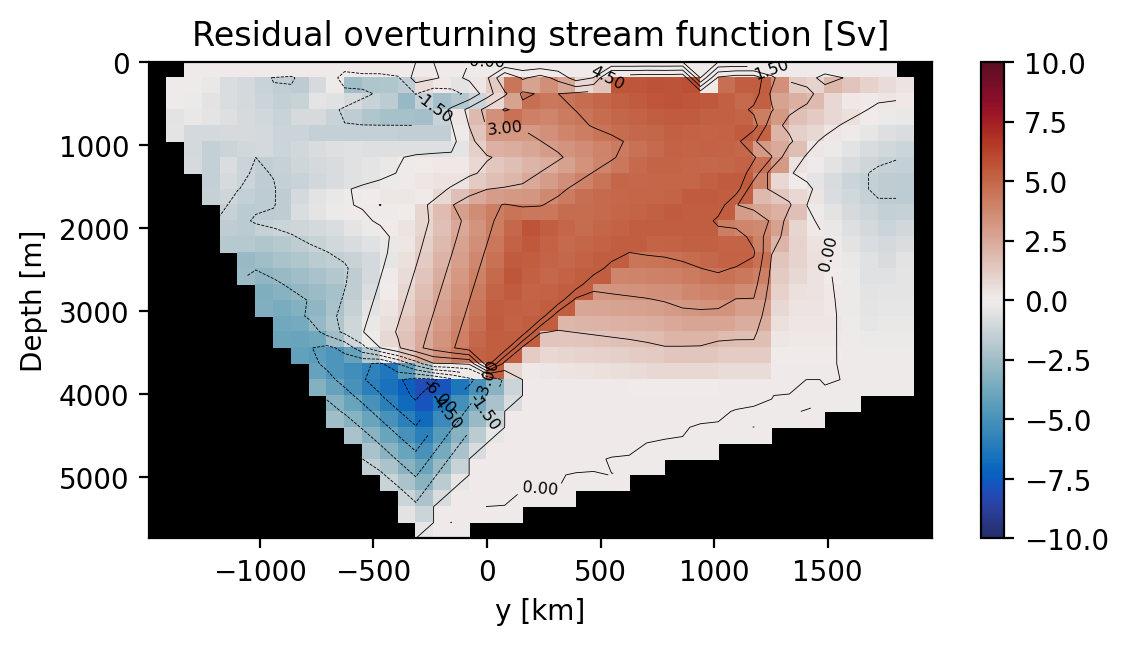

In [39]:
plt.figure(dpi=200, figsize=(2*3.1554, 3.1554))
plt.title(r"Residual overturning stream function [Sv]")
cmap = truncate_colormap(cmocean.cm.balance, 0.05,0.95)
vmin = -10
vmax = 10
plt.pcolormesh(res_ov_depth_cube.coord("y_xmean").points, res_ov_depth_cube.coord("InterpDepth").points, res_ov_depth_cube.data, norm=matplotlib.colors.TwoSlopeNorm(vmin=vmin,vcenter=0, vmax=vmax), cmap=cmap)
plt.colorbar()
CS = plt.contour(res_ov_depth_cube.coord("y_xmean").points, res_ov_depth_cube.coord("InterpDepth").points, res_ov_depth_cube.data, colors='k', linewidths=0.3, levels=11)
plt.clabel(CS, CS.levels, inline=True, fontsize='xx-small', fmt=fmt)
plt.ylabel(r"Depth [m]")
plt.xlabel(r"y [km]")
plt.gca().invert_yaxis()
plt.gca().set_facecolor('k')
plt.savefig(out_dir  + f'/res_ov_depth_xint.{fig_format}', bbox_inches='tight')

# Eddy Kinetic Energy

In [40]:
print(eke_list)

0: eke_xint_ridgewest / (m2 s-2)       (-- : 31; y: 45)
1: eke_xint_fullwidth / (m2 s-2)       (-- : 31; y: 45)
2: eke_xint_noridge / (m2 s-2)         (-- : 31; y: 45)
3: eke_xint_ridgeeast / (m2 s-2)       (-- : 31; y: 45)
4: eke_xint_channel / (m2 s-2)         (-- : 31; y: 45)


(31, 45)
(31, 45)
(31, 45)
(31, 45)
(31, 45)


<ipython-input-41-b265ca43c38c>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.thermal, norm=matplotlib.colors.LogNorm(vmin = 10**(cbarlim_multi-3), vmax = 10**(cbarlim_multi)))
<ipython-input-41-b265ca43c38c>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.thermal, norm=matplotlib.colors.LogNorm(vmin = 10**(c

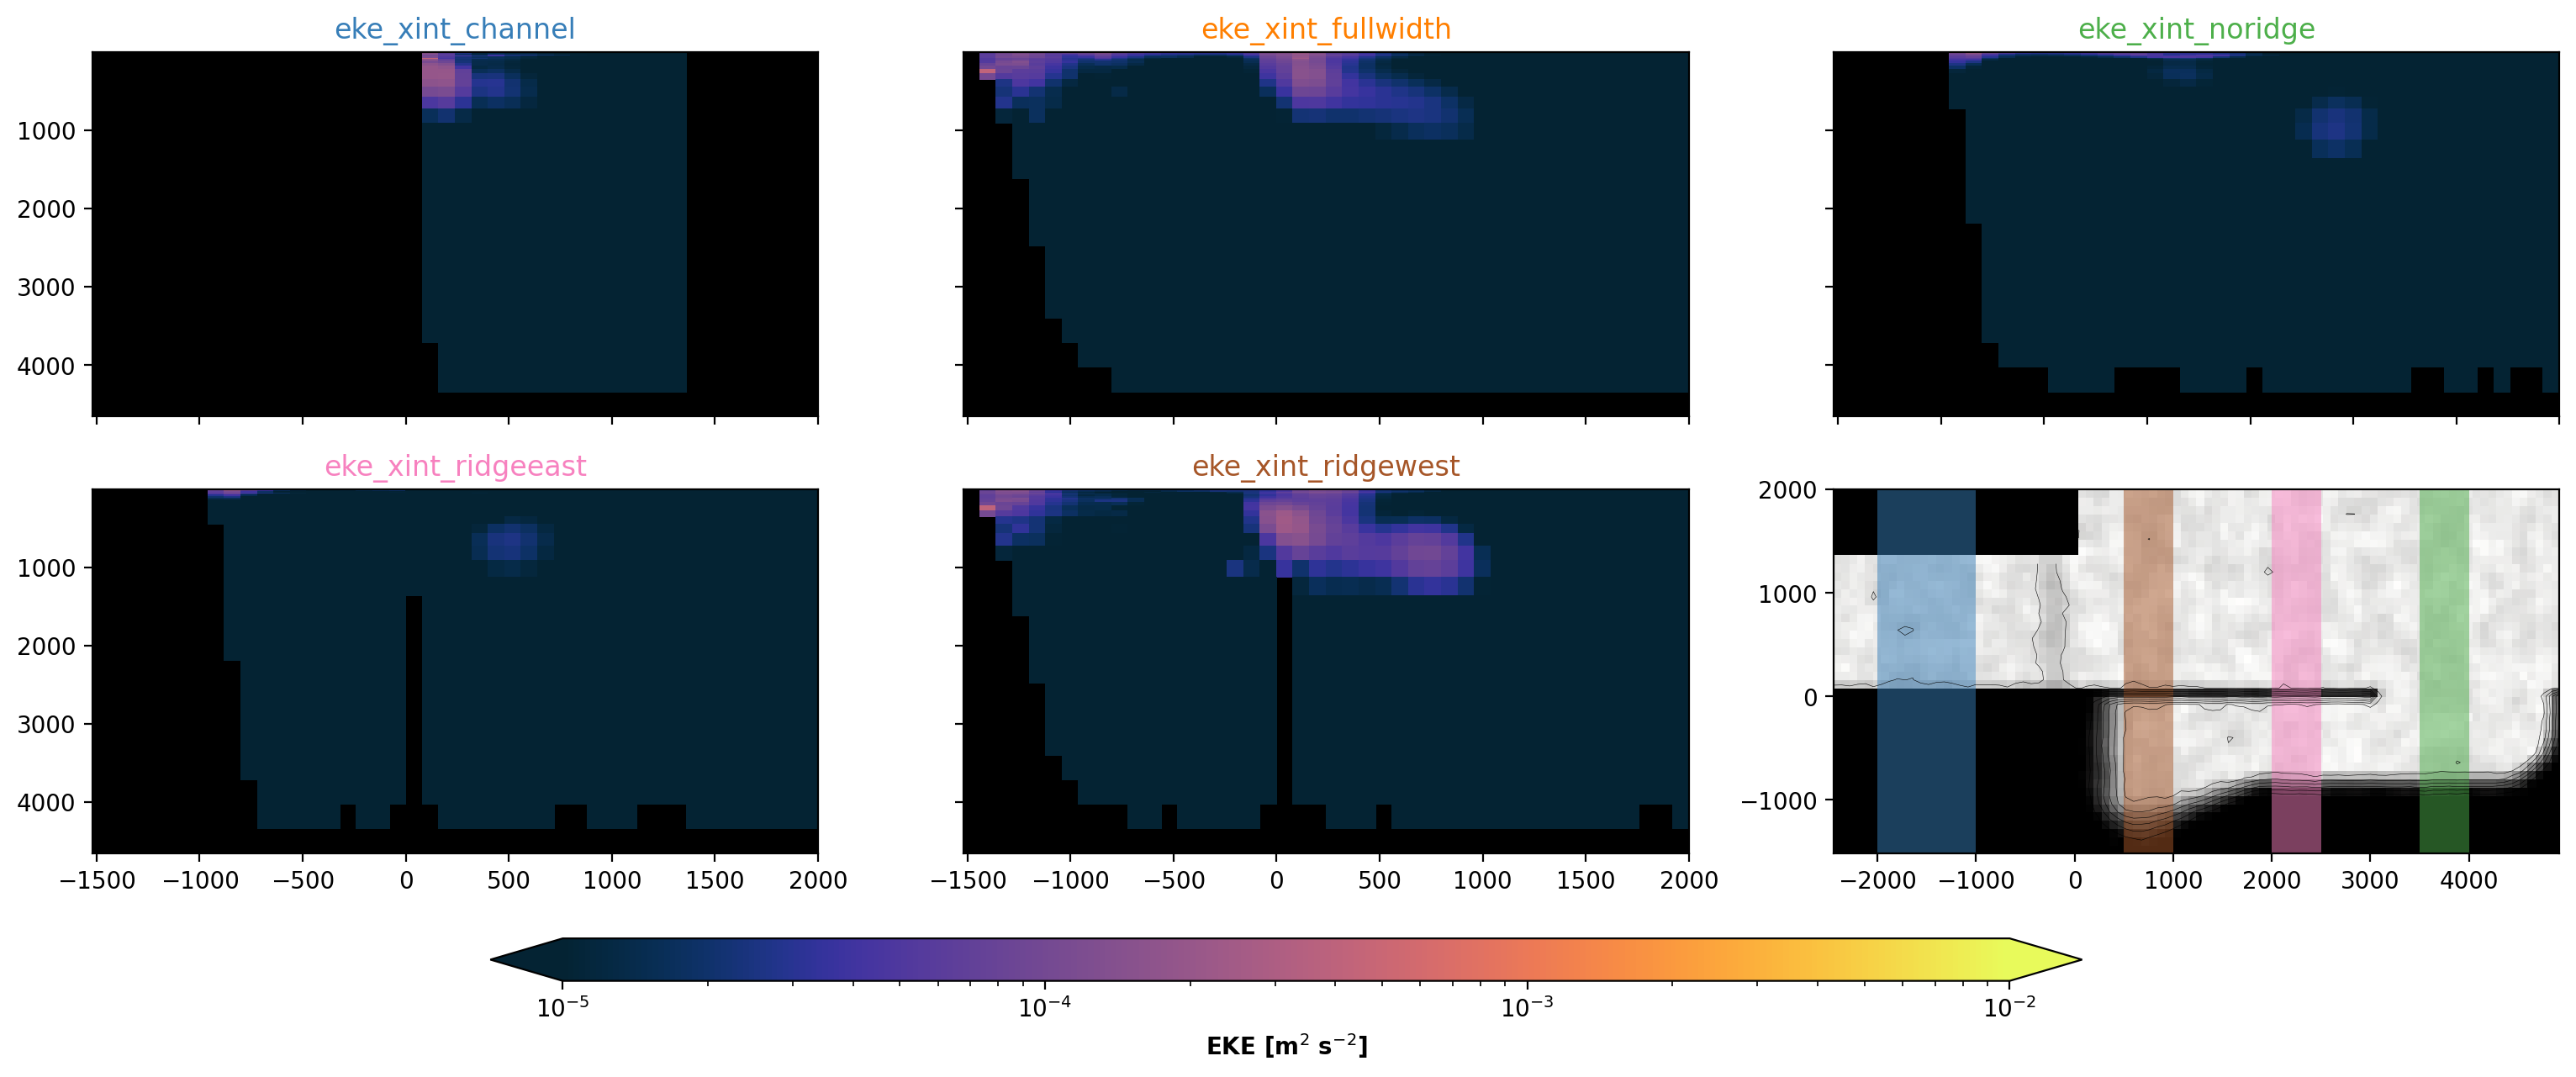

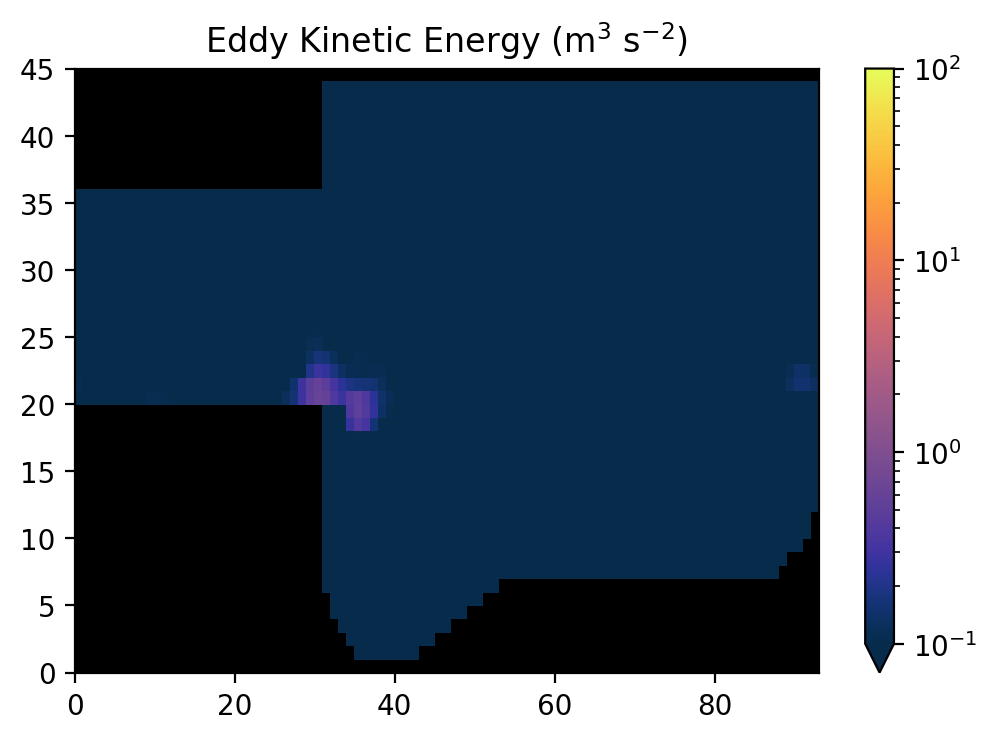

In [41]:
eke_zint = eke_zint_cube.data

# cbarlim = (np.ceil(np.log10(np.max(eke_zint))))
cbarlim = 2

var_names = [cube.var_name for cube in eke_list]
var_names.sort()



nfig = len(eke_list)
nrow = int(np.ceil(nfig/3))
ncol = 3

cbarlim_multi = -2
fig,ax = plt.subplots(nrow, ncol, figsize=(2*ncol*3.1554, nrow*3.1554), dpi=200)

for i in range(nfig):
    irow = int(np.floor(i/ncol)) 
    icol = i - irow * ncol

    cube = CLE(eke_list, var_names[i])
    array = cube.data
    print(array.shape)
    cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.thermal, norm=matplotlib.colors.LogNorm(vmin = 10**(cbarlim_multi-3), vmax = 10**(cbarlim_multi)))
#     CS = ax[irow, icol].contour(lat_1d, depth_1d, array, colors='white', linewidths=0.5, levels=11)
#     ax[irow, icol].clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
    ax[irow, icol].set_facecolor('k')
    ax[irow, icol].set_title(cube.var_name, color=CB_color_cycle[i])
    ax[irow, icol].invert_yaxis()
    
    if icol != 0 : ax[irow, icol].set_yticklabels([])
    if irow != nrow-1 : ax[irow, icol].set_xticklabels([])
        
if nrow*ncol > nfig:
    irow = int(np.floor((nfig)/ncol))
    icol = nfig - irow * ncol
    
    ax[irow, icol].pcolormesh( lon_1d, lat_1d, depth_array, cmap=cmocean.cm.gray )
    ax[irow, icol].contour(lon_1d, lat_1d, depth_array, levels=7, colors='k', linewidths=0.2 )
    ax[irow, icol].set_facecolor('k')
    
    i=0
    for i in range(nfig):
        cube = CLE(eke_list, var_names[i])
        att_dict = cube.attributes
        xmin, xmax = int(att_dict['xmin']), int(att_dict['xmax'])
        ax[irow,icol].fill_between([xmin,xmax], lat_1d.min(), lat_1d.max(), alpha=0.5, color=CB_color_cycle[i], ec=None)
        
        i=i+1
    
ax_bounds = ax[-1,0].get_position().bounds
cbar_ax = fig.add_axes([0.25, ax_bounds[1] -0.12 , 0.5, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"EKE [m$^{2}$ s$^{-2}$]", fontweight='bold')     


fig.savefig(out_dir + f'/eke_xint.{fig_format}', bbox_inches='tight')   


plt.figure(dpi=200)
plt.title(r"Eddy Kinetic Energy (m$^3$ s$^{-2}$)")
thermal_clip = truncate_colormap(cmocean.cm.thermal, minval=0.05)
plt.pcolormesh(eke_zint, norm=matplotlib.colors.LogNorm(vmax=10**cbarlim, vmin=10**(cbarlim-3)), cmap=thermal_clip)
plt.gca().set_facecolor('k')
plt.colorbar(extend='min')
plt.savefig(out_dir  + f'/EKE.{fig_format}', bbox_inches='tight')


# Zonal velocity field

<ipython-input-42-dd83ac3c8b04>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-cbarlim, vmax=cbarlim))
<ipython-input-42-dd83ac3c8b04>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-cbar

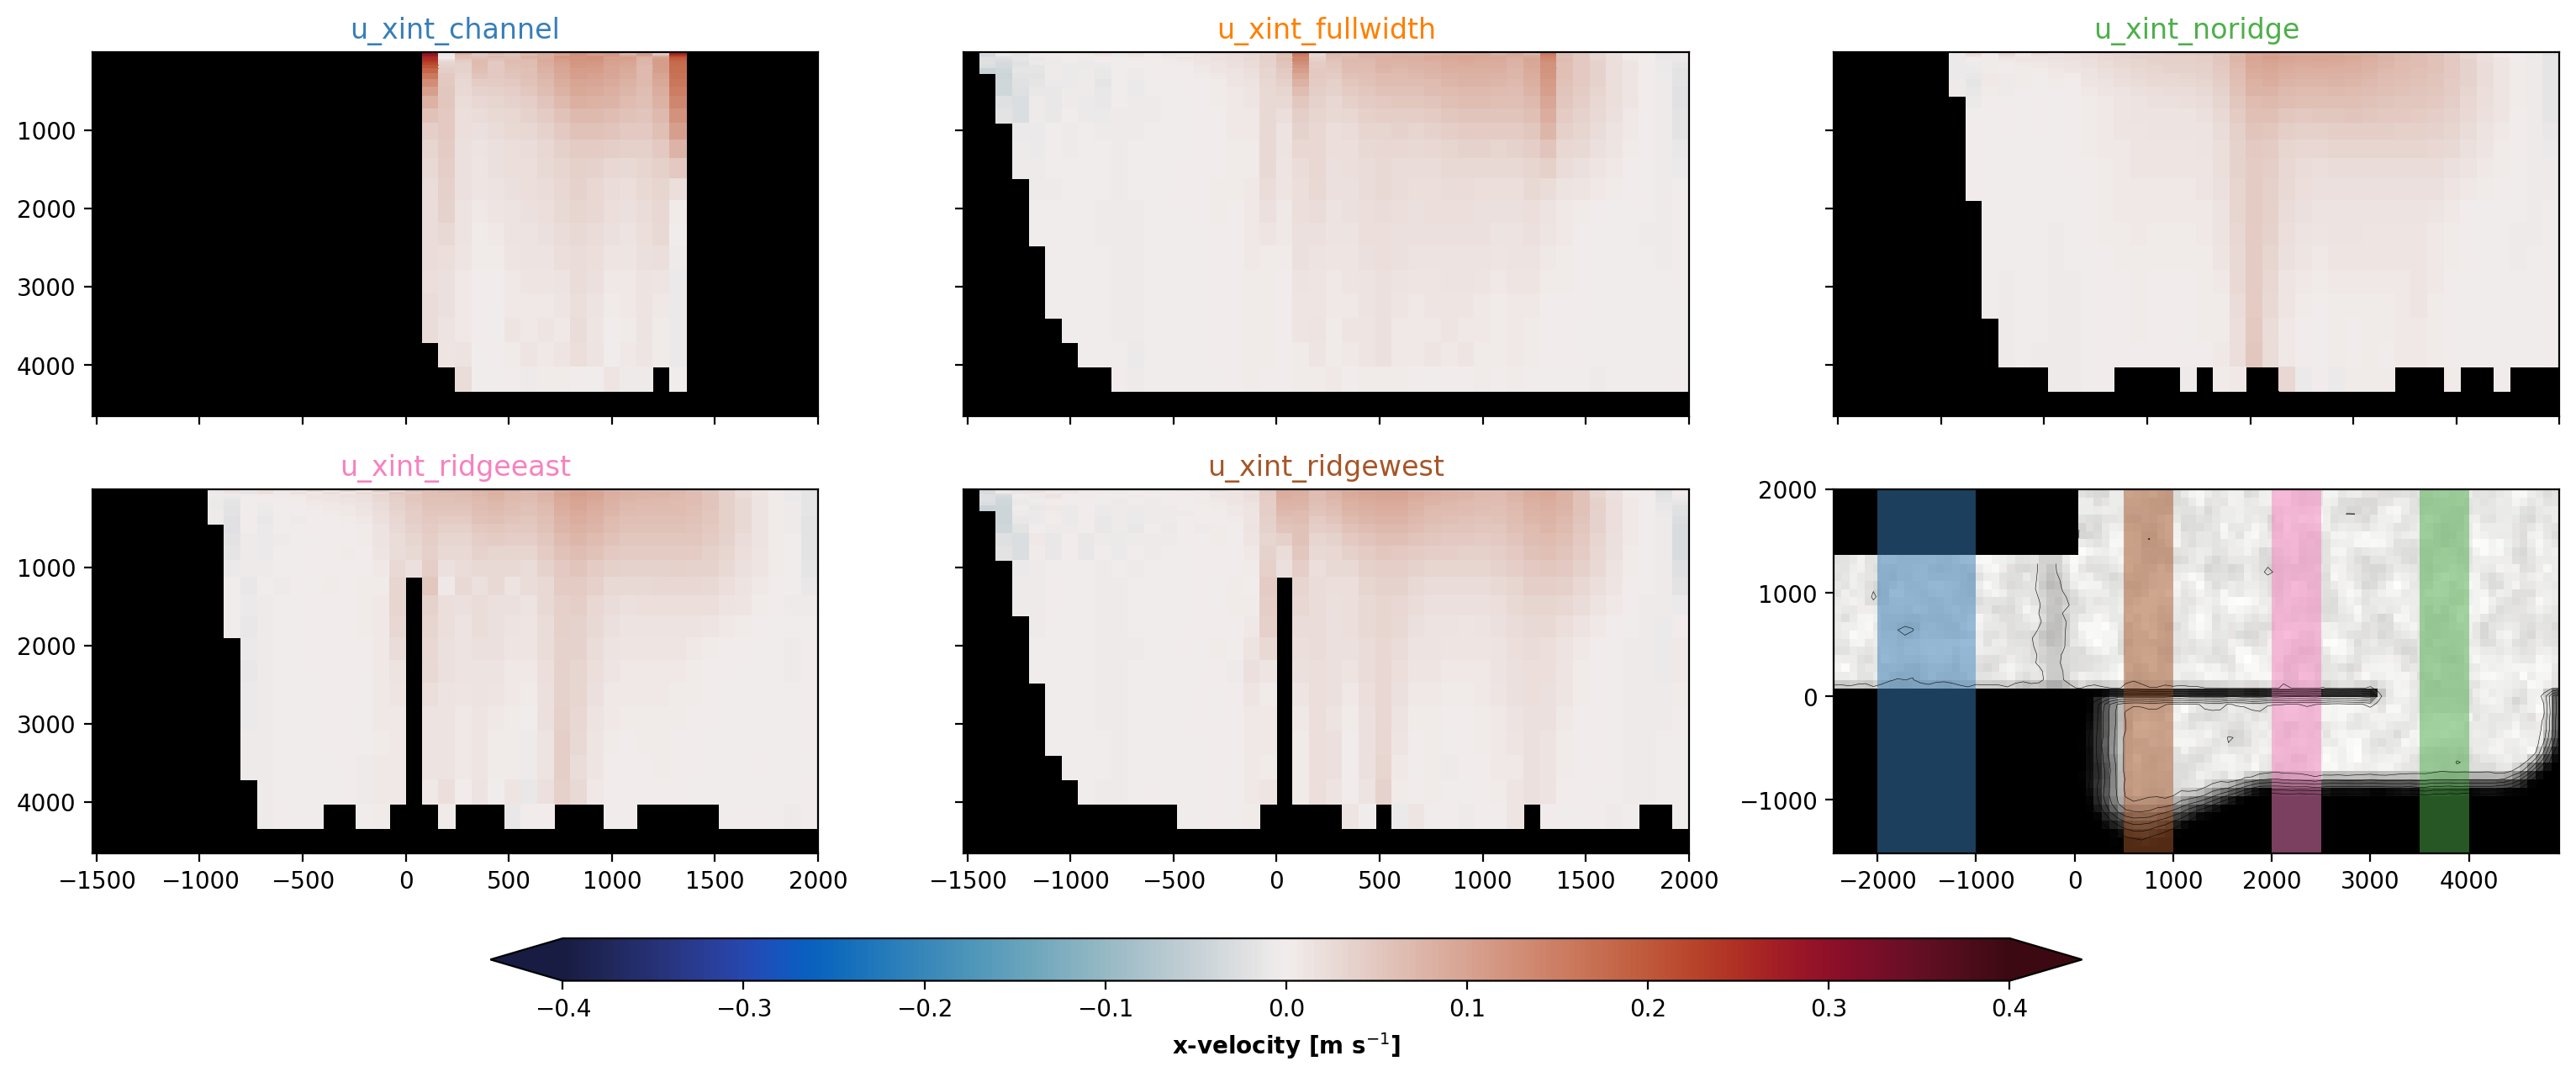

In [42]:
nfig = len(u_list)
nrow = int(np.ceil(nfig/3))
ncol = 3

var_names = [cube.var_name for cube in u_list]
var_names.sort()

cbarlim = 0.4
fig,ax = plt.subplots(nrow, ncol, figsize=(2*ncol*3.1554, nrow*3.1554), dpi=200)

for i in range(nfig):
    irow = int(np.floor(i/ncol)) 
    icol = i - irow * ncol

    cube = CLE(u_list, var_names[i])
    array = np.mean(cube.data, axis=0)
    cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-cbarlim, vmax=cbarlim))
#     CS = ax[irow, icol].contour(lat_1d, depth_1d, array, colors='white', linewidths=0.5, levels=11)
#     ax[irow, icol].clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
    ax[irow, icol].set_facecolor('k')
    ax[irow, icol].set_title(cube.var_name, color=CB_color_cycle[i])
    ax[irow, icol].invert_yaxis()
    
    if icol != 0 : ax[irow, icol].set_yticklabels([])
    if irow != nrow-1 : ax[irow, icol].set_xticklabels([])
        
if nrow*ncol > nfig:
    irow = int(np.floor((nfig)/ncol))
    icol = nfig - irow * ncol
    
    ax[irow, icol].pcolormesh( lon_1d, lat_1d, depth_array, cmap=cmocean.cm.gray )
    ax[irow, icol].contour(lon_1d, lat_1d, depth_array, levels=7, colors='k', linewidths=0.2 )
    ax[irow, icol].set_facecolor('k')
    
    i=0
    for i in range(nfig):
        cube = CLE(u_list, var_names[i])
        att_dict = cube.attributes
        xmin, xmax = int(att_dict['xmin']), int(att_dict['xmax'])
        ax[irow,icol].fill_between([xmin,xmax], lat_1d.min(), lat_1d.max(), alpha=0.5, color=CB_color_cycle[i], ec=None)
        
        i=i+1
    
ax_bounds = ax[-1,0].get_position().bounds
cbar_ax = fig.add_axes([0.25, ax_bounds[1] -0.12 , 0.5, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"x-velocity [m s$^{-1}$]", fontweight='bold')     
fig.savefig(out_dir + f'/u_xint.{fig_format}', bbox_inches='tight')   

# Meridional velocity field

<ipython-input-43-12975958b975>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-cbarlim, vmax=cbarlim))
<ipython-input-43-12975958b975>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-cbar

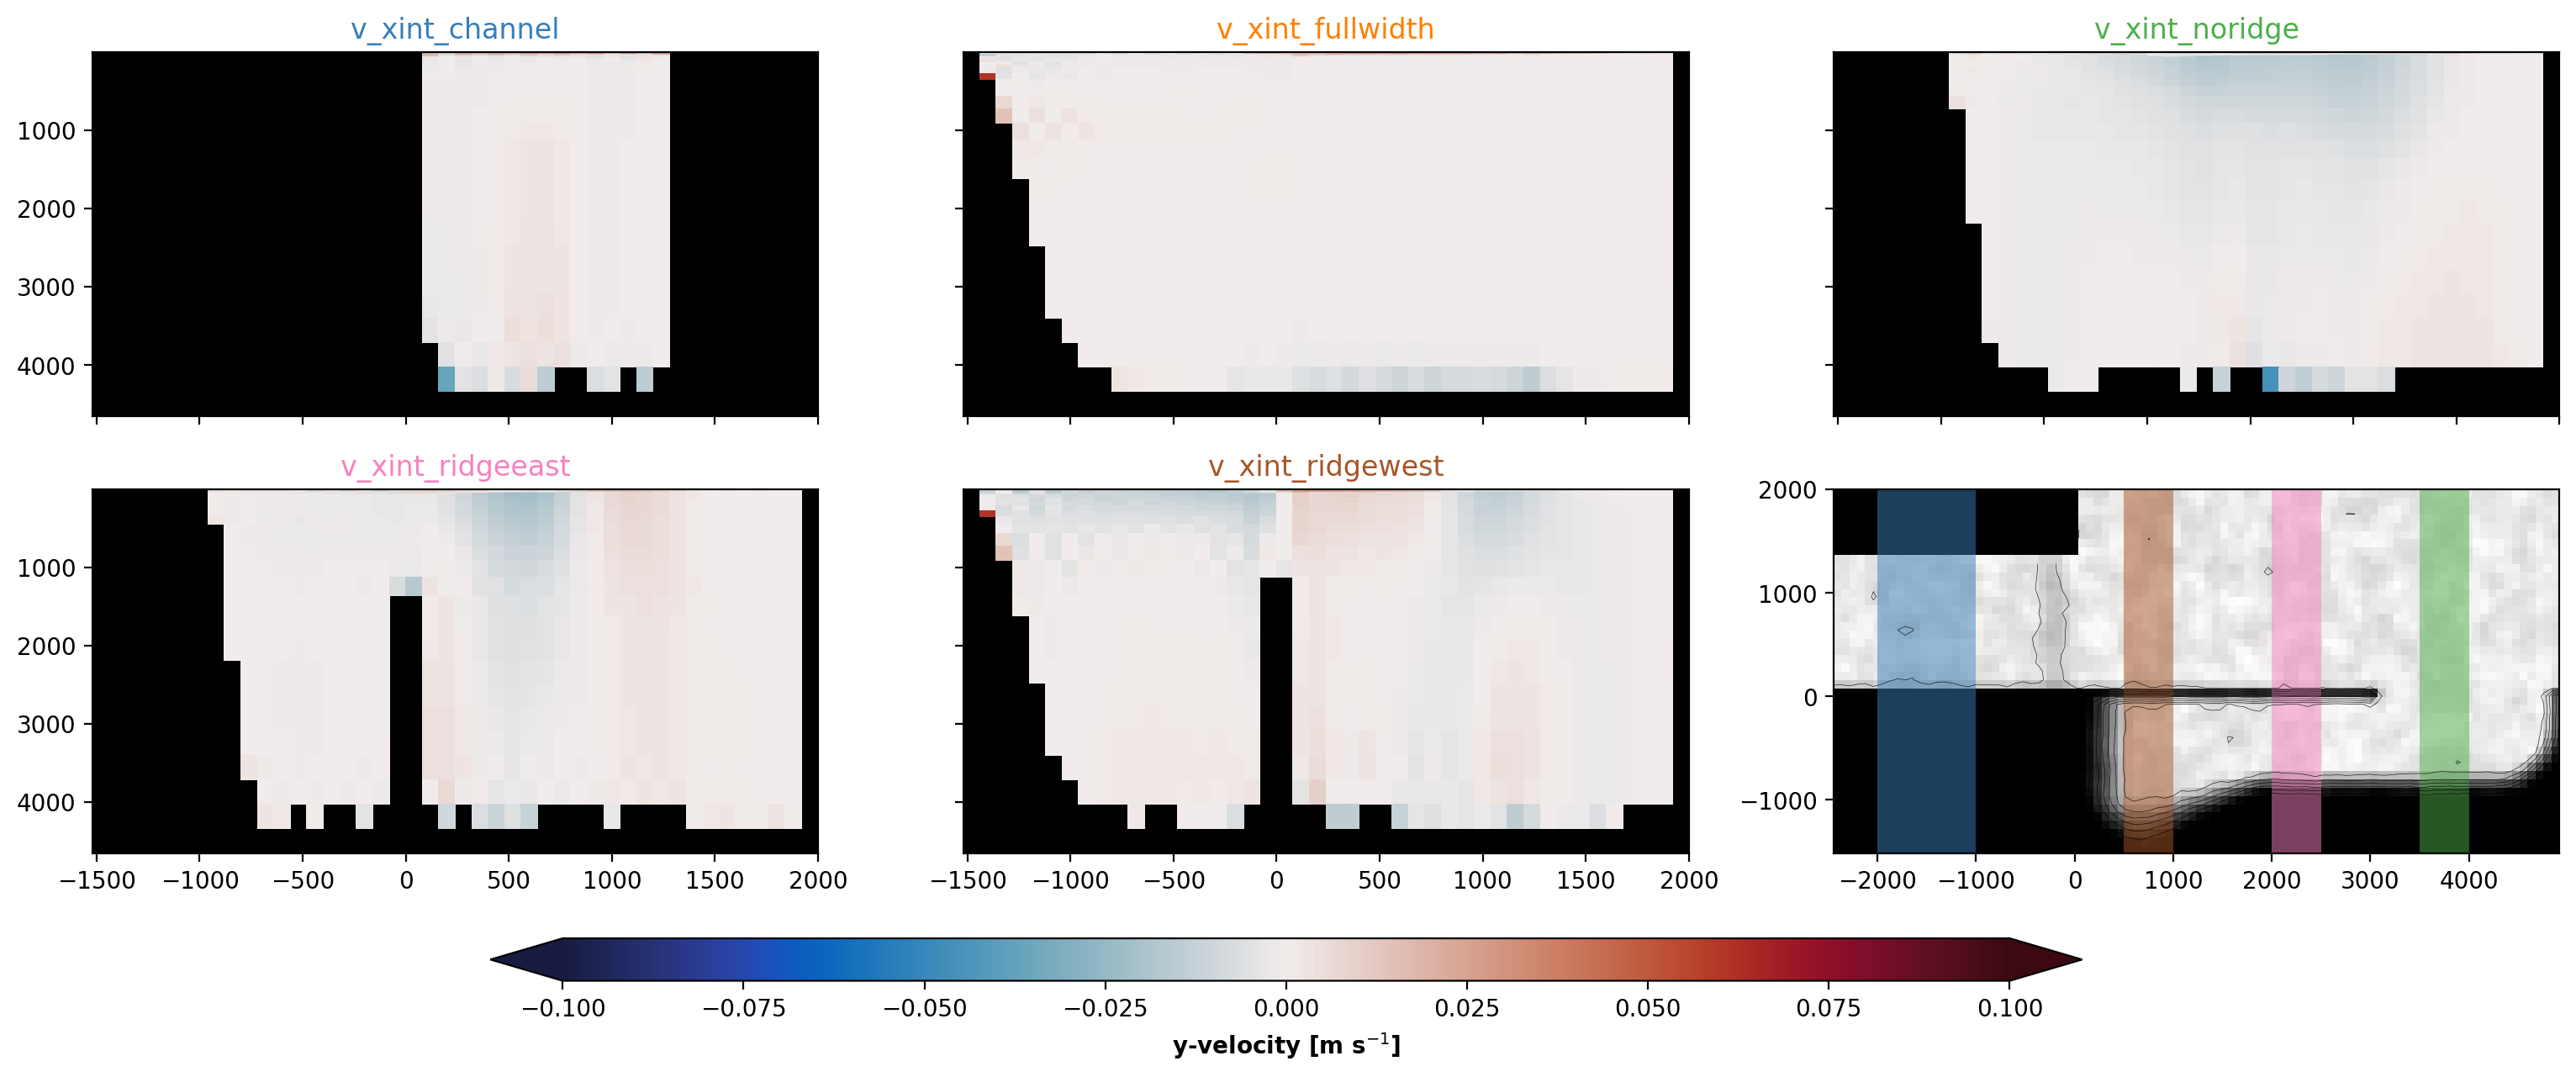

In [43]:
nfig = len(u_list)
nrow = int(np.ceil(nfig/3))
ncol = 3

var_names = [cube.var_name for cube in v_list]
var_names.sort()


cbarlim = 0.1
fig,ax = plt.subplots(nrow, ncol, figsize=(2*ncol*3.1554, nrow*3.1554), dpi=200)

for i in range(nfig):
    irow = int(np.floor(i/ncol)) 
    icol = i - irow * ncol

    cube = CLE(v_list, var_names[i])
    array = np.mean(cube.data, axis=0)
    cax = ax[irow, icol].pcolormesh(lat_1d, depth_1d, array, cmap=cmocean.cm.balance, norm=matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-cbarlim, vmax=cbarlim))
#     CS = ax[irow, icol].contour(lat_1d, depth_1d, array, colors='white', linewidths=0.5, levels=11)
#     ax[irow, icol].clabel(CS, CS.levels, inline=True, fontsize='x-small', fmt=fmt)
    ax[irow, icol].set_facecolor('k')
    ax[irow, icol].set_title(cube.var_name, color=CB_color_cycle[i])
    ax[irow, icol].invert_yaxis()
    
    if icol != 0 : ax[irow, icol].set_yticklabels([])
    if irow != nrow-1 : ax[irow, icol].set_xticklabels([])
        
if nrow*ncol > nfig:
    irow = int(np.floor((nfig)/ncol))
    icol = nfig - irow * ncol
    
    ax[irow, icol].pcolormesh( lon_1d, lat_1d, depth_array, cmap=cmocean.cm.gray )
    ax[irow, icol].contour(lon_1d, lat_1d, depth_array, levels=7, colors='k', linewidths=0.2 )
    ax[irow, icol].set_facecolor('k')
    
    i=0
    for i in range(nfig):
        cube = CLE(v_list, var_names[i])
        att_dict = cube.attributes
        xmin, xmax = int(att_dict['xmin']), int(att_dict['xmax'])
        ax[irow,icol].fill_between([xmin,xmax], lat_1d.min(), lat_1d.max(), alpha=0.5, color=CB_color_cycle[i], ec=None)
        
        i=i+1
    
ax_bounds = ax[-1,0].get_position().bounds
cbar_ax = fig.add_axes([0.25, ax_bounds[1] -0.12 , 0.5, 0.04 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', extend='both')
clb.set_label(r"y-velocity [m s$^{-1}$]", fontweight='bold')     
fig.savefig(out_dir + f'/v_xint.{fig_format}', bbox_inches='tight')   

# Time series (COMPLETE)

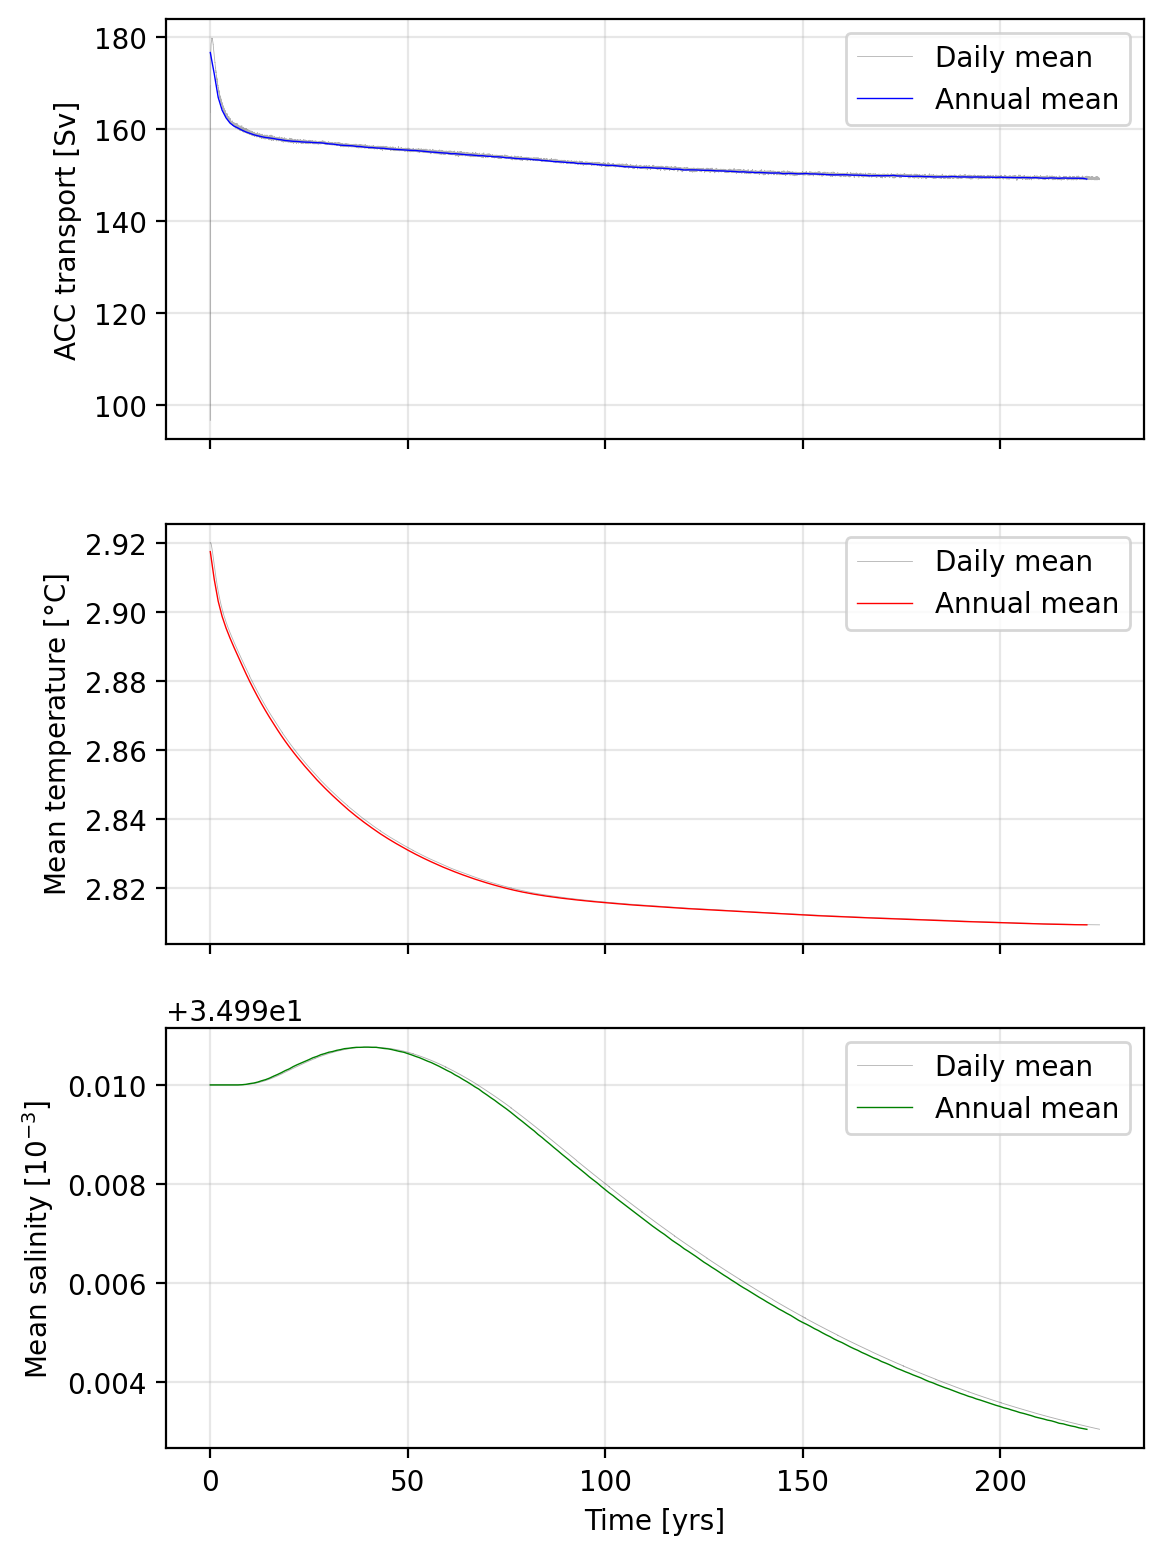

In [44]:
fig, ax = plt.subplots(3,1,dpi=200,figsize=(2*3.1554, 3*3.1554), sharex=True)
line_opts = {'linewidth':0.3, 'color':'k'}
time_coord = (ts_acc_cube.coords()[0].points - ts_acc_cube.coords()[0].points[0])/(360*24*60*60)



ax[0].plot(time_coord, ts_acc_cube.data/1e6, **line_opts, alpha=0.3, label='Daily mean')
ax[0].plot(ts_acc_cube.aggregated_by(["year"], iris.analysis.MEAN).data/1e6, color='blue', linewidth='0.5', label='Annual mean' )
ax[0].grid(True, alpha=0.3)
ax[0].legend()
ax[0].set_ylabel(r"ACC transport [Sv]")

ax[1].plot(time_coord, ts_tem_cube.data, **line_opts, alpha=0.3, label='Daily mean')
ax[1].plot(ts_tem_cube.aggregated_by(["year"], iris.analysis.MEAN).data, color='red', linewidth='0.5', label='Annual mean' )
ax[1].grid(True, alpha=0.3)
ax[1].legend()
ax[1].set_ylabel(r"Mean temperature [$\degree$C]")

ax[2].plot(time_coord, ts_sal_cube.data, **line_opts, alpha=0.3, label='Daily mean')
ax[2].plot(ts_sal_cube.aggregated_by(["year"], iris.analysis.MEAN).data, color='green', linewidth='0.5', label='Annual mean' )
ax[2].legend()
ax[2].grid(True, alpha=0.3)
ax[2].set_xlabel(r"Time [yrs]")
ax[2].set_ylabel(r"Mean salinity [10$^{-3}$]")

fig.savefig(out_dir  + f'/long_timeseries.{fig_format}', bbox_inches='tight')



# Contour Integrals (Vorticity budget)

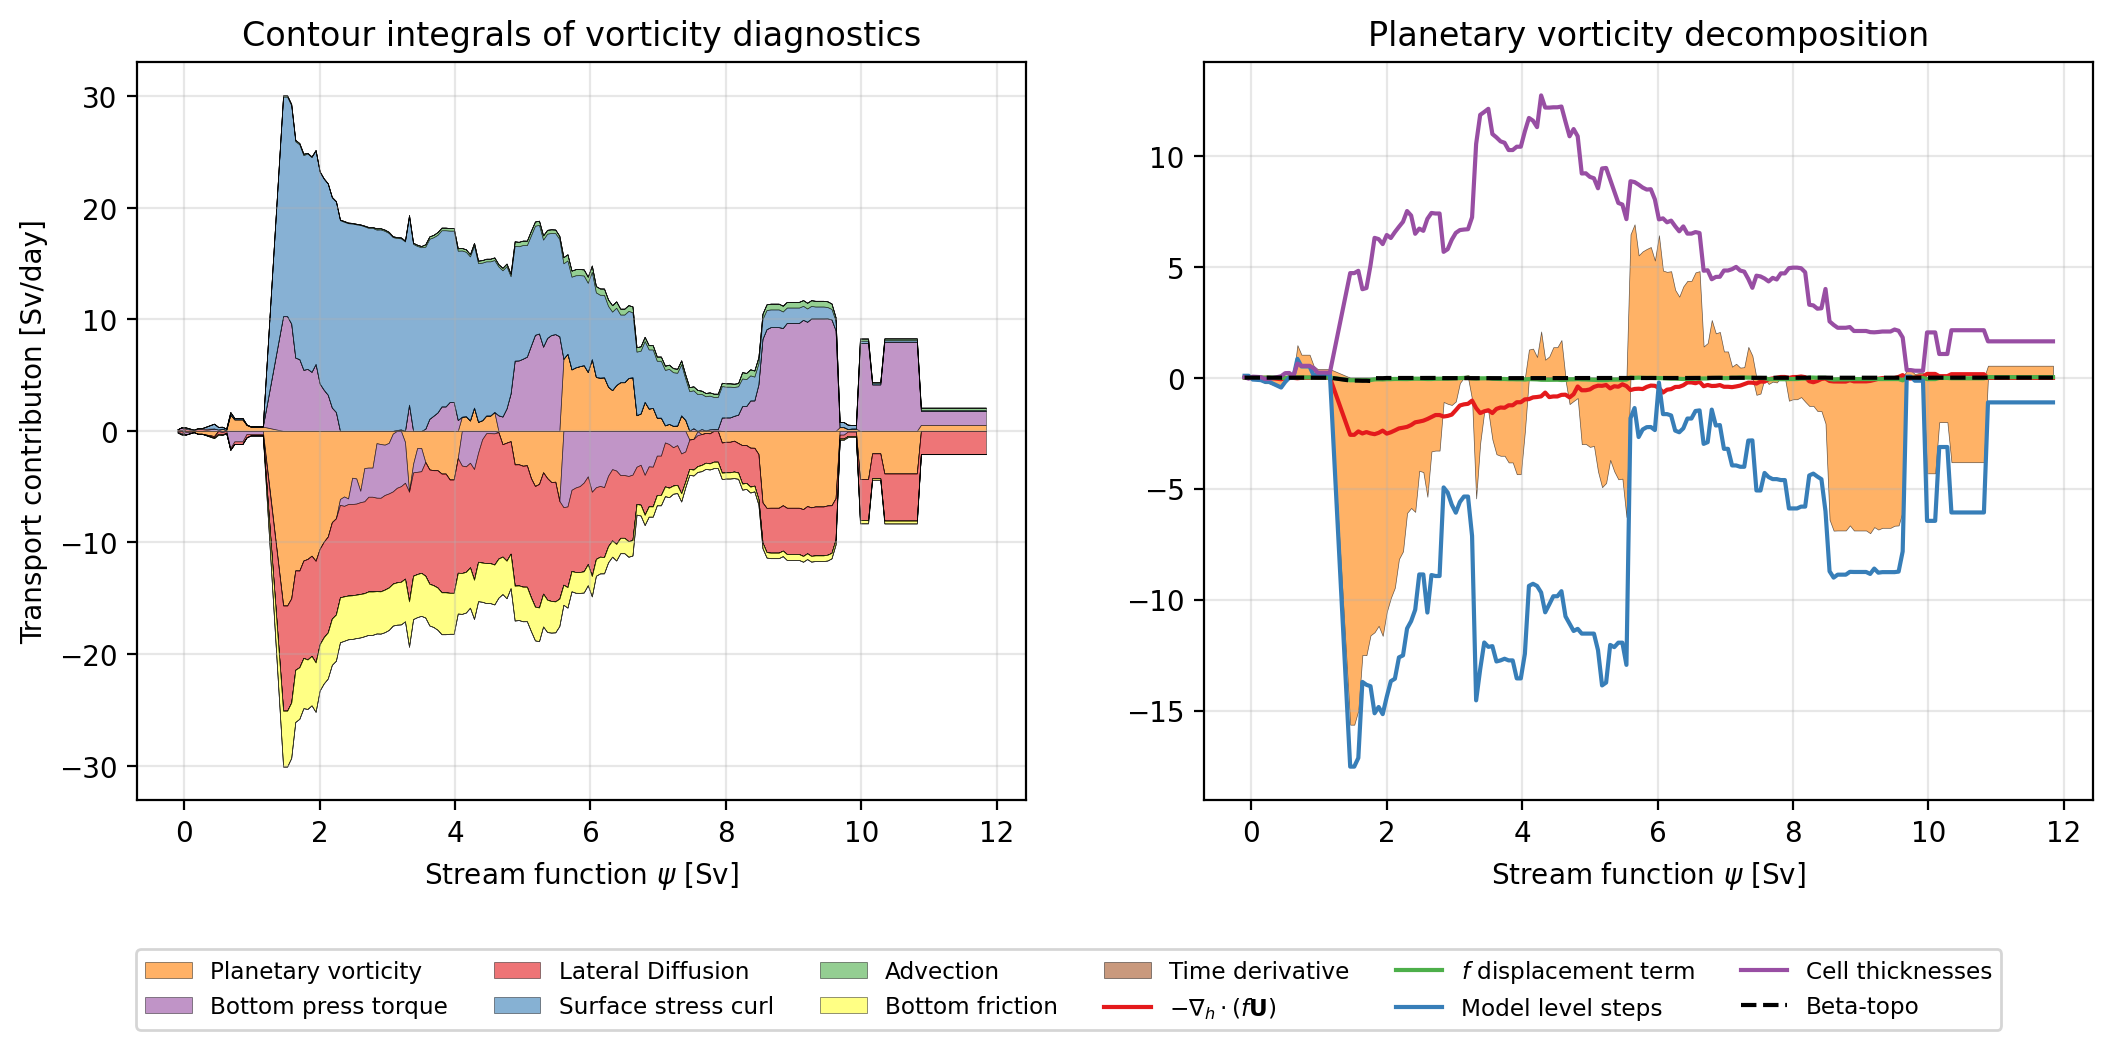

In [45]:
def setsign(NI_int, level_int):
    NI_int[level_int > 0] = -NI_int[level_int > 0]
    return NI_int

def splitbysign(NI_int):
    
    output_plus = np.zeros(NI_int.shape)
    output_neg = np.zeros(NI_int.shape)
    
    output_plus[NI_int >= 0] = NI_int[NI_int >= 0]
    output_neg[NI_int < 0] = NI_int[NI_int < 0]
    
    return output_plus, output_neg

diag_list = ['ADV', 'HPG', 'LDF', 'PVO', 'RES', 'TOT', 'FRC', 'WND', 'DIV', 'BET', 'PRC', 'MLV']

fig, ax = plt.subplots(1,2,figsize=(4*3.1554, 1.5*3.1554), dpi=200)
legend_list = ['Planetary vorticity'    , 'Bottom press torque'    ,'Lateral Diffusion'    ,'Surface stress curl'  ,  'Advection'    ,'Bottom friction'    ,'Time derivative'    ]
color_list = ['#ff7f00','#984ea3','#e41a1c','#377eb8','#4daf4a','#ffff33','#a65628']
plot_opts = {'alpha':0.6 , 'edgecolor':'k', 'lw':0.25, 'colors':color_list, 'labels':legend_list, 'antialiased':True}


ax[0].set_title(fr"Contour integrals of vorticity diagnostics")
ax[0].set_xlabel(r"Stream function $\psi$ [Sv]")
ax[0].set_ylabel(r"Transport contributon [Sv/day]")
ax[1].set_title(fr"Planetary vorticity decomposition")
ax[1].set_xlabel(r"Stream function $\psi$ [Sv]")


NI_dict = {}

NI_cube_list = iris.load( f"{VCAN_dir}/NI_2D_vort_*.*.nc")

for diag in diag_list:
    NI_dict[diag] = CLE(NI_cube_list, 'Ni2D_'+diag)

area_out = NI_dict['ADV'].coord("enclosed_area").points
level_out = NI_dict['ADV'].coord("sf_zint_level").points


NI_dict_largest = {}
NI_dict_plus = {}
NI_dict_minus = {}


for diag in NI_dict:
    NI_dict_largest[diag], level_out_largest = take_largest_contour(NI_dict[diag].data*1e-6*86400, level_out, area_out)
    NI_dict_largest[diag] = setsign(NI_dict_largest[diag], level_out_largest)
    NI_dict_plus[diag], NI_dict_minus[diag] = splitbysign(NI_dict_largest[diag])

ax[0].stackplot(level_out_largest,
                   np.abs(NI_dict_plus['PVO']),
                   np.abs(NI_dict_plus['HPG']),
                   np.abs(NI_dict_plus['LDF']),
                   np.abs(NI_dict_plus['WND']),
                   np.abs(NI_dict_plus['ADV']),
                   np.abs(NI_dict_plus['FRC']),
                   np.abs(NI_dict_plus['TOT']), **plot_opts)

ax[1].plot(level_out_largest, NI_dict_largest['DIV'], label=r'$-\nabla_h\cdot\left(f\mathbf{U}\right)$', color='#e41a1c')
ax[1].plot(level_out_largest, NI_dict_largest['BET'], label='$f$ displacement term', color='#4daf4a')
ax[1].plot(level_out_largest, NI_dict_largest['MLV'], label='Model level steps', color='#377eb8')
ax[1].plot(level_out_largest, NI_dict_largest['PRC'], label='Cell thicknesses', color='#984ea3')
ax[1].plot(level_out_largest, NI_dict_largest['PVO'] - (NI_dict_largest['BET'] + NI_dict_largest['MLV'] + NI_dict_largest['PRC'] + NI_dict_largest['DIV']), label=r"Beta-topo", color='k', linestyle='dashed')



fig.subplots_adjust(bottom=0.1, hspace=0.5)
fig.legend(bbox_to_anchor=(0.12,-0.1), loc='center left', ncol=6, fontsize='small')

ax[1].stackplot(level_out_largest,
                   np.abs(NI_dict_plus['PVO']), **plot_opts)
ax[1].stackplot(level_out_largest,
                   -np.abs(NI_dict_minus['PVO']), **plot_opts)

ax[0].stackplot(level_out_largest,
                   -np.abs(NI_dict_minus['PVO']),
                   -np.abs(NI_dict_minus['HPG']),
                   -np.abs(NI_dict_minus['LDF']),
                   -np.abs(NI_dict_minus['WND']),
                   -np.abs(NI_dict_minus['ADV']),
                   -np.abs(NI_dict_minus['FRC']),
                   -np.abs(NI_dict_minus['TOT']), **plot_opts)

# ax[0].set_xlim([0,None])
ax[0].grid(True, alpha=0.3)
ax[1].grid(True, alpha=0.3)

fig.savefig(out_dir  + f'/NI.{fig_format}', bbox_inches='tight')

# Grid point vorticity diagnostics

0: k-curl of depth-integrated total advection trend / (m/s2) (time: 196; -- : 45; -- : 95)
1: PVO contribution due to f displacement term / (m/s2) (time: 196; -- : 45; -- : 95)
2: Calculation of divh(fU) / (m/s2)    (time: 196; -- : 45; -- : 95)
3: Calculation of f divh(U) / (m/s2)   (time: 196; -- : 45; -- : 95)
4: Calculation of f divh(U) / (m/s2)   (time: 196; -- : 45; -- : 95)
5: k-curl of depth-integrated lateral friction (partial ZDF) trend / (m/s2) (time: 196; -- : 45; -- : 95)
6: k-curl of depth-integrated horizontal pressure gradient trend / (m/s2) (time: 196; -- : 45; -- : 95)
7: k-curl of depth-integrated kinetic energy gradient trend / (m/s2) (time: 196; -- : 45; -- : 95)
8: k-curl of depth-integrated lateral diffusion trend / (m/s2) (time: 196; -- : 45; -- : 95)
9: PVO contribution due to changes in lowest model level / (m/s2) (time: 196; -- : 45; -- : 95)
10: PVO contribution due to varying cell thickness / (m/s2) (time: 196; -- : 45; -- : 95)
11: k-curl of depth-integrat

<ipython-input-46-efcc10d5ee0e>:89: UserWarning: shading value 'goraud' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  cax = ax[i][j].pcolormesh(lon, lat, M, cmap=cmocean.cm.balance, norm=divnorm, shading='goraud', rasterized=True)
<ipython-input-46-efcc10d5ee0e>:122: UserWarning: shading value 'goraud' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  cax = ax[i][j].pcolormesh(lon, lat, M, cmap=cmocean.cm.balance, norm=divnorm, shading='goraud', rasterized=True)


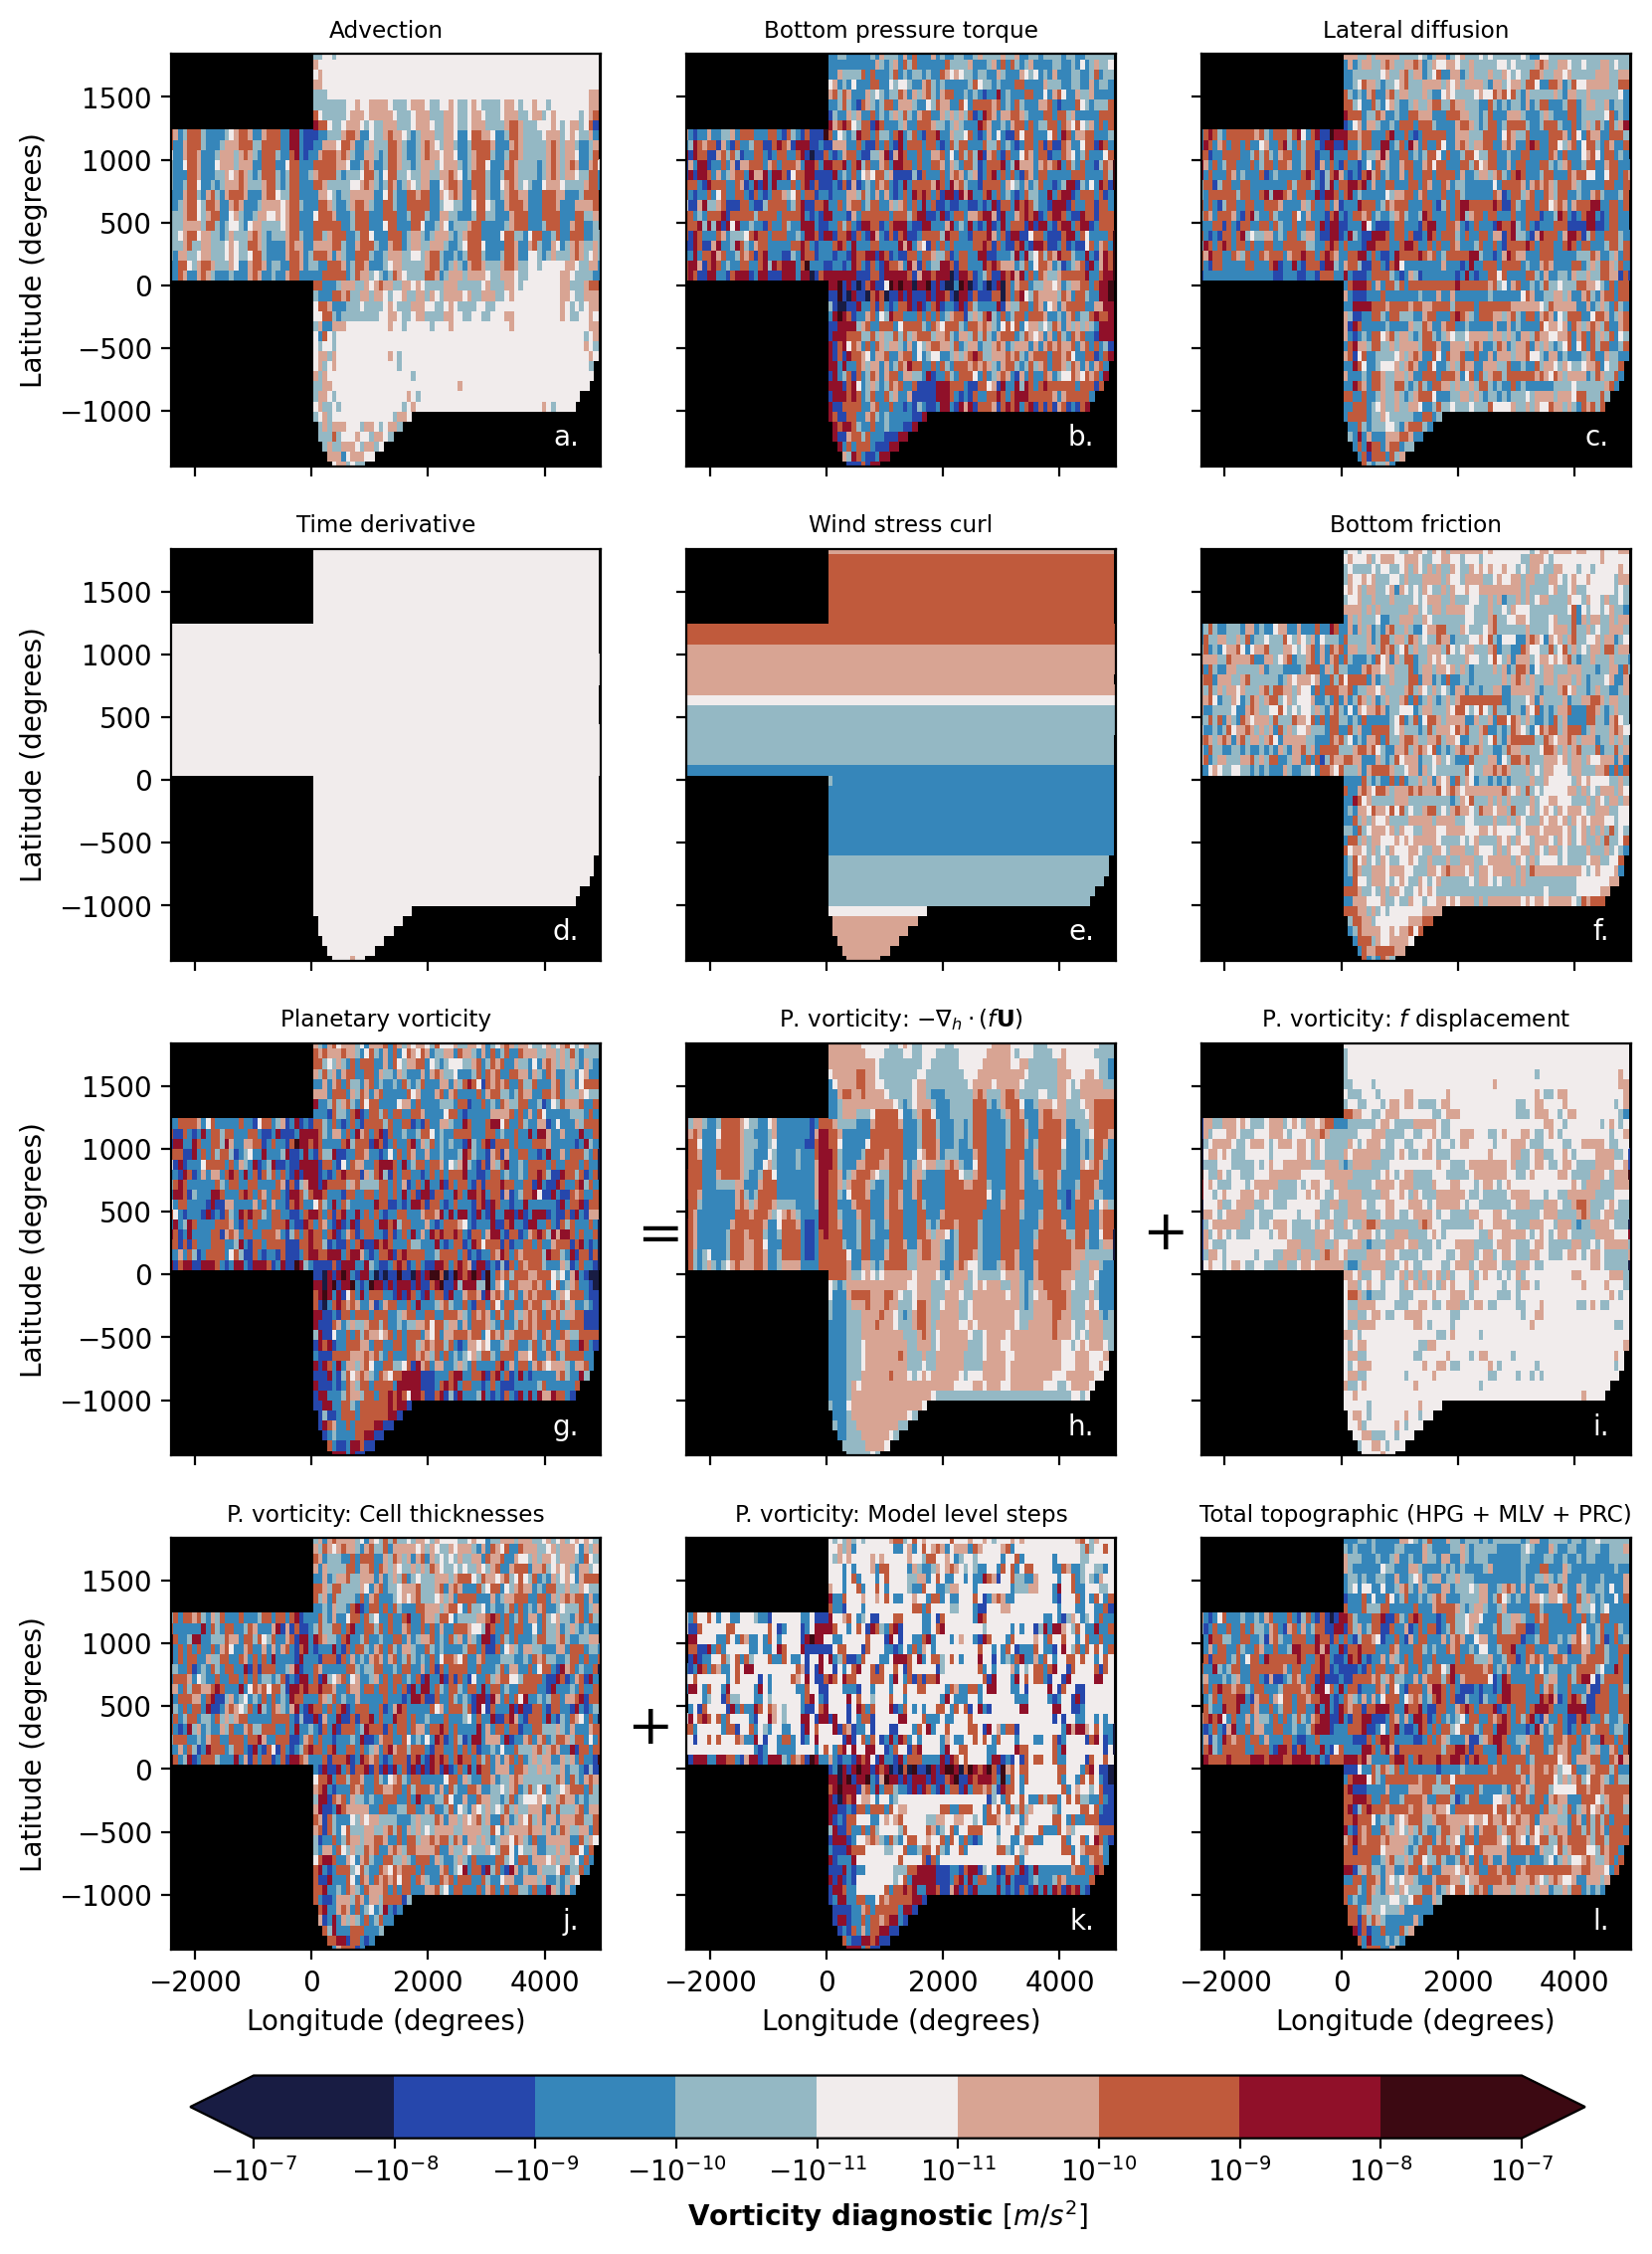

In [46]:
vort_dict = {}
smoothing = False

vort_diag_list = iris.load(f"{VCAN_dir}/vort_2D_*.*.nc")
print(vort_diag_list)
vort_dict = {}



for cube in vort_diag_list:
    label = cube.var_name[5:-5]
    array = np.mean(cube.data, axis=0)
    
    if label == 'mlv': vort_dict['mlv_unsmoothed'] = array
                    
    if smoothing == True:            
            smooth_array = np.zeros(array.shape)
            smooth_area = np.zeros(array.shape)
            
            for ny in np.arange(-2,2+1):
                for nx in np.arange(-2,2+1):
                    smooth_array = smooth_array + roll_and_mask(roll_and_mask(array*fcell_area, ny, axis=-2),nx, axis=-1)
                    smooth_area = smooth_area + roll_and_mask(roll_and_mask(fcell_area, ny, axis=-2),nx, axis=-1)
                    
            array = smooth_array/smooth_area
            
            
            
    
    vort_dict[label] = array
    
    

vort_dict['cpl'] = vort_dict['pvo']-vort_dict['bet']-vort_dict['mlv']-vort_dict['prc']-vort_dict['div']
vort_dict['top'] = vort_dict['mlv']+vort_dict['hpg']+vort_dict['prc']
    
lon = vort_diag_list[0].coord("longitude").points
lat = vort_diag_list[0].coord("latitude").points

max_lon = np.max(np.ma.masked_array(lon, mask=vort_diag_list[0].data.mask[-1,...]))
min_lon = np.min(np.ma.masked_array(lon, mask=vort_diag_list[0].data.mask[-1,...]))
max_lat = np.max(np.ma.masked_array(lat, mask=vort_diag_list[0].data.mask[-1,...]))
min_lat = np.min(np.ma.masked_array(lat, mask=vort_diag_list[0].data.mask[-1,...]))

long_names = {'adv':"Advection",
              'hpg':"Bottom pressure torque",
              'ldf':r"Lateral diffusion",
#               'pvo': "Planetary vorticity",
#               'res': "Residual",
              'tot': "Time derivative",
              'wnd': "Wind stress curl",
              'frc': "Bottom friction" }

long_names_PVO = {'pvo': "Planetary vorticity",
#                   'pvo2': "Offline calculation of PVO",
                  'div': r"P. vorticity: $-\nabla_h\cdot\left(f\mathbf{U}\right)$",
                  'bet':r"P. vorticity: $f$ displacement",
                  'prc': "P. vorticity: Cell thicknesses",
                  'mlv': "P. vorticity: Model level steps",
                  'top':r"Total topographic (HPG + MLV + PRC)"}


fig, ax = plt.subplots(4,3,dpi=200, figsize=(3*3.1554,4*3.1554), sharex=True, sharey=True)


i=0
j=0

# cbar_max = np.log10(np.max([np.max(np.abs(X[...,:])) for X in vort_dict.values()]))
# cbar_max = np.floor(cbar_max)

cbar_max = -7

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    if x < 0: return r'$-10^{{{}}}$'.format(b)
    if x >= 0: return r'$10^{{{}}}$'.format(b)

cmap=cmocean.cm.balance
levels = np.append(-np.logspace(cbar_max, cbar_max-4, num=5),np.logspace(cbar_max-4,cbar_max, num=5))

lab_no = 0

for label in long_names:
    M = vort_dict[label]
    divnorm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    ax[i][j].set_title(long_names[label], fontsize='small')
    cax = ax[i][j].pcolormesh(lon, lat, M, cmap=cmocean.cm.balance, norm=divnorm, shading='goraud', rasterized=True)
    ax[i][j].set_xlim(min_lon, max_lon)
    ax[i][j].set_ylim(min_lat, max_lat)
    ax[i][j].set_facecolor('k')

    ax[i][j].text(0.95,0.05, fr"{ascii_lowercase[lab_no]}.", transform=ax[i][j].transAxes, color='white', ha='right')
    lab_no = lab_no + 1
        
    if j==2:
        j=0
        i=i+1
    else: j=j+1
        
ax_bounds = ax[-1,0].get_position().bounds
cbar_ax = fig.add_axes([ax_bounds[0] + 0.01, ax_bounds[1] -0.075 , 3.25*ax_bounds[2], 0.025 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', format=matplotlib.ticker.FuncFormatter(fmt), extend='both')
clb.set_label(r"Vorticity diagnostic $[m/s^2]$", fontweight='bold')     

# fig, ax = plt.subplots(2,3,dpi=dpi, figsize=(3*3.1554,2*3.1554), sharex=True, sharey=True)

# i=0
# j=0



for label in long_names_PVO:
    M = vort_dict[label]
    
    if label == 'mlv': 
        M = vort_dict['mlv_unsmoothed']
        if smoothing == True: ax[i][j].text(0.95,0.14, fr"Not smoothed", transform=ax[i][j].transAxes, color='white', ha='right') 
    divnorm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    ax[i][j].set_title(long_names_PVO[label], fontsize='small')
    cax = ax[i][j].pcolormesh(lon, lat, M, cmap=cmocean.cm.balance, norm=divnorm, shading='goraud', rasterized=True)
    ax[i][j].set_xlim(min_lon, max_lon)
    ax[i][j].set_ylim(min_lat, max_lat)
    ax[i][j].set_facecolor('k')
    ax[i][j].text(0.95,0.05, fr"{ascii_lowercase[lab_no]}.", transform=ax[i][j].transAxes, color='white', ha='right')
    
    lab_no = lab_no + 1

    if j==2:
        j=0
        i=i+1
    else: j=j+1

ax_bounds = ax[-1,0].get_position().bounds

ax[2][0].text(1.06,0.5,r"$=$", transform=ax[2][0].transAxes, fontsize=20)
ax[2][1].text(1.06,0.5,r"$+$", transform=ax[2][1].transAxes, fontsize=20)
ax[3][0].text(1.06,0.5,r"$+$", transform=ax[3][0].transAxes, fontsize=20)
# ax[3][1].text(1.06,0.5,r"$+$", transform=ax[3][1].transAxes, fontsize=20)
# cbar_ax = fig.add_axes([ax_bounds[0] + 0.01, ax_bounds[1] -0.1 , 3.75*(ax_bounds[2] - 0.02), 0.025 ])
# clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal')
# clb.set_label(r"$\log_{10}$|Barotropic Vorticity| $[m/s^2]$", fontweight='bold')     

ax[-1,0].set_xlabel(r"Longitude (degrees)")
ax[-1,1].set_xlabel(r"Longitude (degrees)")
ax[-1,2].set_xlabel(r"Longitude (degrees)")

ax[0,0].set_ylabel(r"Latitude (degrees)")
ax[1,0].set_ylabel(r"Latitude (degrees)")
ax[2,0].set_ylabel(r"Latitude (degrees)")
ax[3,0].set_ylabel(r"Latitude (degrees)")

fig.savefig(out_dir  + f'/VD.{fig_format}', bbox_inches='tight')
        

# Diagnostic Cross Section

In [ ]:
fig, ax = plt.subplots(2,1,dpi=200, figsize=(2*3.1554,2*3.1554), sharex=True, sharey=True)
xcoord = 2000 # x coordinate of cross section (km)
ymin = -500
ymax = +500
xind = np.argmin(np.abs(lon[0,:] - xcoord))
yind1 = np.argmin(np.abs(lat[:,0] - ymin))
yind2 = np.argmin(np.abs(lat[:,0] - ymax))
print(yind1, yind2)


color_list = ['#4daf4a','#984ea3','#e41a1c', '#a65628', '#377eb8', '#ffff33', '#ff7f00']

ax0_twin = ax[0].twinx()
ax0_twin.plot(tm(sf_zint_cube.data)[yind1:yind2,xind], color='k', label=r"$\psi$")
ylim_twin = np.max(np.abs(ax0_twin.get_ylim()))
ax0_twin.set_ylim( -ylim_twin, ylim_twin )
ax0_twin.grid(True, alpha=0.3)

i=0

for label in long_names:
    M = vort_dict[label]
    ax[0].plot(M[yind1:yind2,xind], label = label, color=color_list[i])
    i=i+1

ax[0].plot(vort_dict['pvo'][yind1:yind2,xind], label='pvo', color=color_list[i])
ax[0].plot(vort_dict['top'][yind1:yind2,xind], label='top', color='gray', linestyle='dashed')
ax[1].plot(vort_dict['pvo'][yind1:yind2,xind], label='pvo', color=color_list[i])

ylim = np.max(np.abs(ax[0].get_ylim()))
ax[0].set_ylim(-ylim, ylim)
ax[0].legend(loc = 'center right')

ax1_twin = ax[1].twinx()
ax1_twin.plot(tm(sf_zint_cube.data)[yind1:yind2,xind], color='k', label=r"$\psi$")
ylim_twin = np.max(np.abs(ax1_twin.get_ylim()))
ax1_twin.set_ylim( -ylim_twin, ylim_twin )
ax1_twin.grid(True, alpha=0.3)

color_list = ['#ff7f00', '#4daf4a','#984ea3','#e41a1c', '#a65628', '#377eb8', '#ffff33']

ax[1].plot( vort_dict['div'][yind1:yind2,xind], label=r'$-\nabla_h\cdot\left(f\mathbf{U}\right)$', color='#e41a1c')
ax[1].plot( vort_dict['bet'][yind1:yind2,xind], label='$f$ displacement term', color='#4daf4a')
ax[1].plot( vort_dict['mlv'][yind1:yind2,xind], label='Model level steps', color='#377eb8')
ax[1].plot( vort_dict['prc'][yind1:yind2,xind], label='Cell thicknesses', color='#984ea3')


ax[1].legend(loc='center right')

# Grid point momentum diagnostics

In [47]:
cube_dict = {
'u_keg' : CLE(data_list, 'utrd_swkeg'),
'u_rvo' : CLE(data_list, 'utrd_swrvo'),
'u_pvo' : CLE(data_list, 'utrd_swpvo'),
'u_hpg' : CLE(data_list, 'utrd_swhpg'),
'u_ldf' : CLE(data_list, 'utrd_swldf'),
'u_zdf' : CLE(data_list, 'utrd_swzdf'),
'u_zad' : CLE(data_list, 'utrd_swzad'),
'u_tot' : CLE(data_list, 'utrd_swtot'),
'u_tau' : CLE(data_list, 'utrd_swtau'), #Needs halving

'v_keg' : CLE(data_list, 'vtrd_swkeg'),
'v_rvo' : CLE(data_list, 'vtrd_swrvo'),
'v_pvo' : CLE(data_list, 'vtrd_swpvo'),
'v_hpg' : CLE(data_list, 'vtrd_swhpg'),
'v_ldf' : CLE(data_list, 'vtrd_swldf'),
'v_zdf' : CLE(data_list, 'vtrd_swzdf'),
'v_zad' : CLE(data_list, 'vtrd_swzad'),
'v_tot' : CLE(data_list, 'vtrd_swtot'),
'v_tau' : CLE(data_list, 'vtrd_swtau'), #Needs halving
    
}

NameError: name 'data_list' is not defined

NameError: name 'cube_dict' is not defined

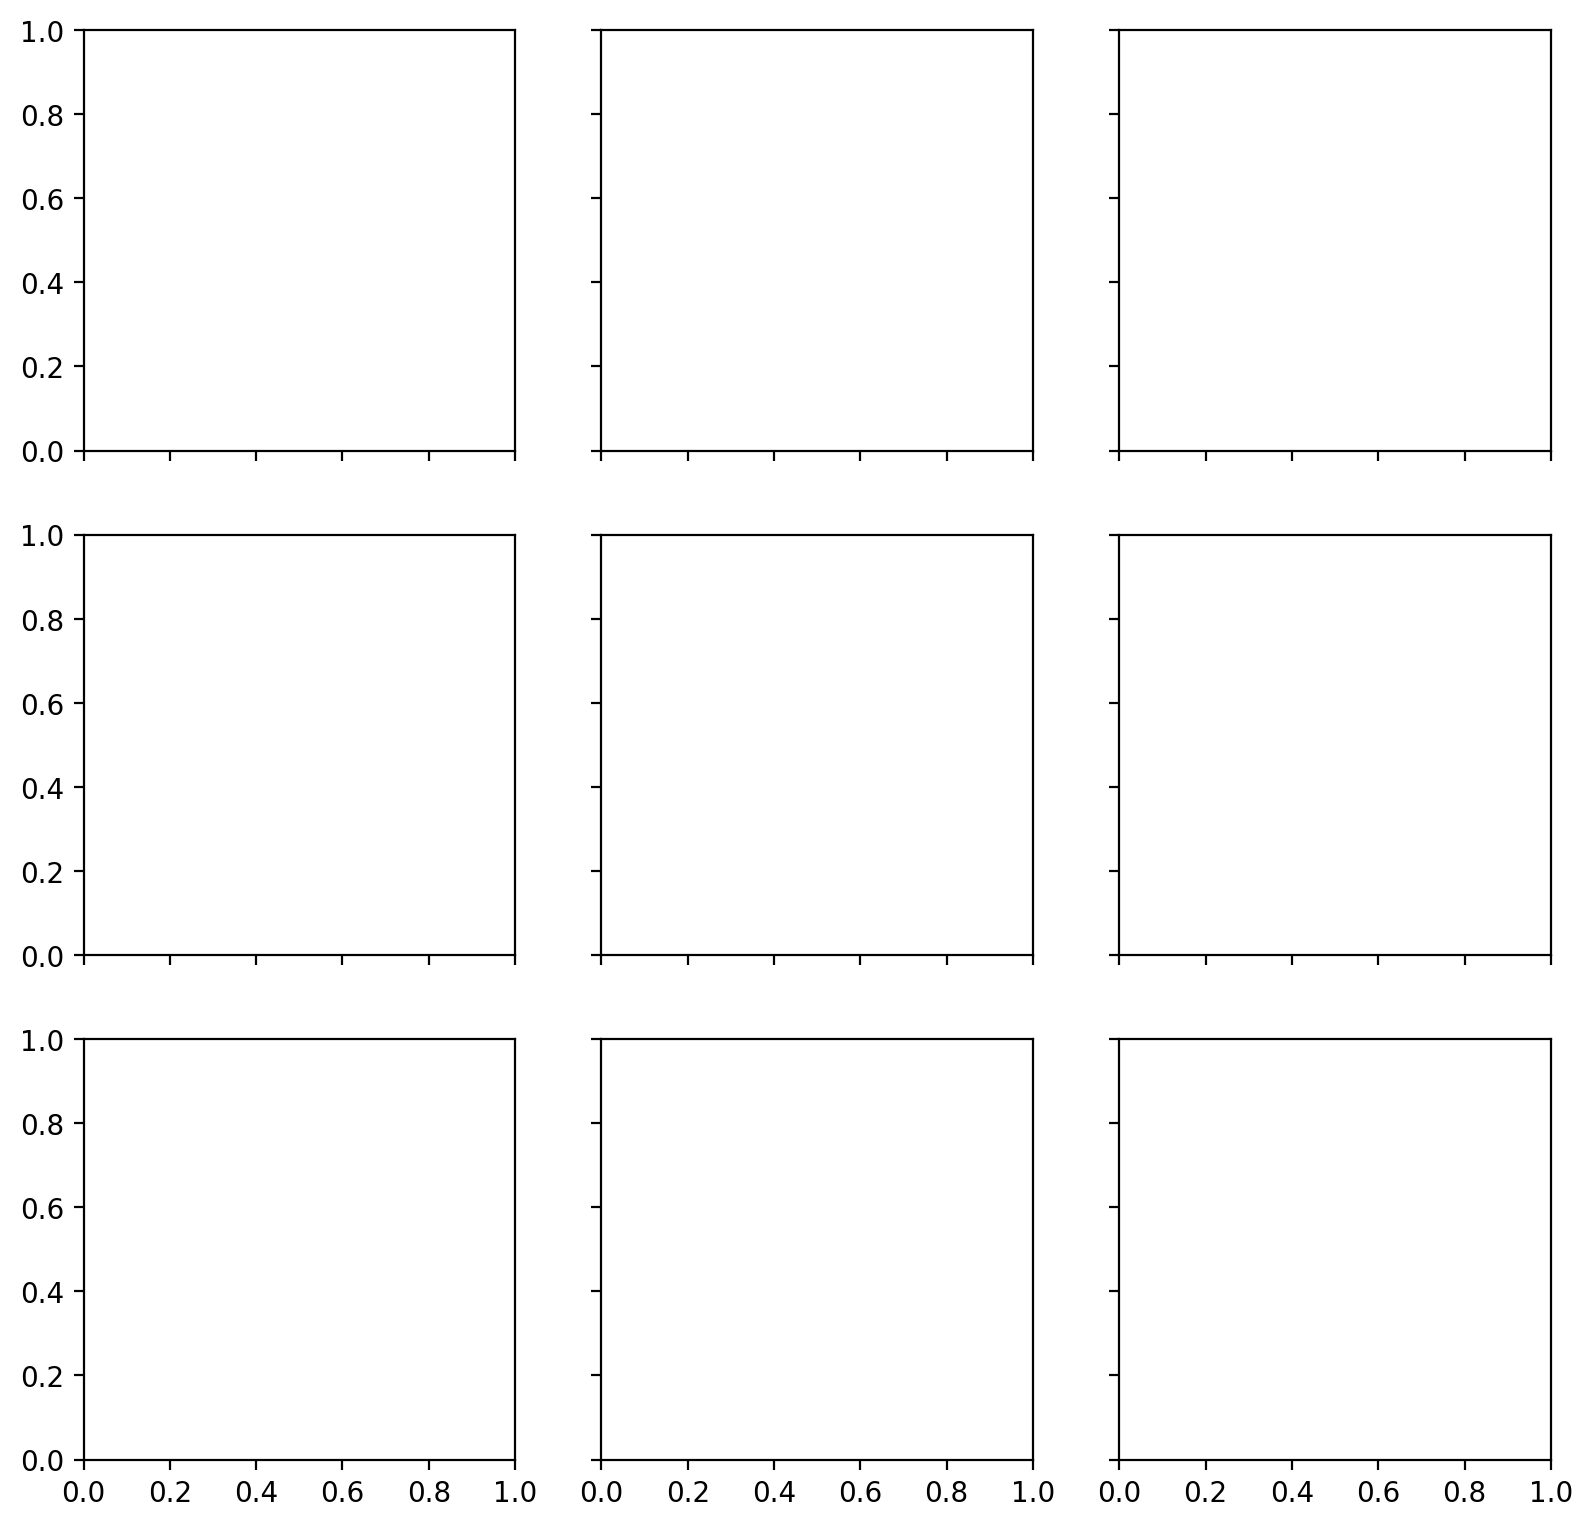

In [48]:
# label_list = ['pvo', 'hpg', 'adv', 'wnd','frc', 'ldf', 'tot']
label_list = ['adv', 'pvo', 'ldf', 'hpg', 'wnd', 'frc', 'tot']
ind_dict = { 'adv': (0,0), 'pvo' : (2,0), 'ldf':(0,2), 'hpg':(0,1) ,'wnd':(1,1), 'frc':(1,2), 'tot':(1,0)}
long_names = {'adv':"Advection",
              'hpg':"Pressure gradient",
              'ldf':r"Lateral diffusion",
              'pvo': "Coriolis acceleration",
              'tot': "Time derivative",
              'wnd': "Wind stress",
              'frc': "Bottom friction" }


fig, ax = plt.subplots(3,3, figsize=(3*3.1554, 3*3.1554), dpi=200, sharex=True, sharey=True)
cbar_max = -2

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    if x < 0: return r'$-10^{{{}}}$'.format(b)
    if x >= 0: return r'$10^{{{}}}$'.format(b)

cmap=cmocean.cm.balance
levels = np.append(-np.logspace(cbar_max, cbar_max-4, num=5),np.logspace(cbar_max-4,cbar_max, num=5))

for label in label_list:
    
    if label == 'adv':   
        u_array = np.sum(tm(cube_dict['u_keg'].data[...,1:-1] + cube_dict['u_rvo'].data[...,1:-1] + cube_dict['u_zad'].data[...,1:-1])*e3u, axis=-3)
        
    elif label == 'wnd':
        u_array = tm(cube_dict['u_tau'].data[...,1:-1]) * e3u[0,...]/2

    elif label == 'frc':
        u_array =  u_array = np.sum( tm(cube_dict['u_zdf'].data[...,1:-1])*e3u, axis=-3 ) - tm(cube_dict['u_tau'].data[...,1:-1]) * e3u[0,...]/2
        
    else:
        u_array = np.sum( tm(cube_dict['u_'+label].data[...,1:-1])*e3u, axis=-3 )
        
    u_array = np.ma.masked_array(u_array, mask=~np.ma.make_mask(umaskutil))
        
        
    ind1, ind2 = ind_dict[label]
    norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    ax[ind1, ind2].set_title(long_names[label], fontsize='small')
    cax = ax[ind1, ind2].pcolormesh(lon_1d, lat_1d, u_array, cmap=cmocean.cm.balance, norm=norm, shading='goraud', rasterized=True)
    ax[ind1, ind2].set_facecolor('k')
    
cbar_ax = fig.add_axes([ax_bounds[0] + 0.01, ax_bounds[1] -0.075 , 3.25*ax_bounds[2], 0.025 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', format=matplotlib.ticker.FuncFormatter(fmt), extend='both')
clb.set_label(r"X-momentum diagnostic $[m^2/s^2]$", fontweight='bold')   

ax[-1,0].set_xlabel(r"x (km)")
ax[-1,1].set_xlabel(r"x (km)")
ax[-1,2].set_xlabel(r"x (km)")

ax[0,0].set_ylabel(r"y (km)")
ax[1,0].set_ylabel(r"y (km)")
ax[2,0].set_ylabel(r"y (km)")

fig.savefig(out_dir  + f'/MDX.{fig_format}', bbox_inches='tight')

fig, ax = plt.subplots(3,3, figsize=(3*3.1554, 3*3.1554), dpi=200, sharex=True, sharey=True)

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    if x < 0: return r'$-10^{{{}}}$'.format(b)
    if x >= 0: return r'$10^{{{}}}$'.format(b)

cmap=cmocean.cm.balance
levels = np.append(-np.logspace(cbar_max, cbar_max-4, num=5),np.logspace(cbar_max-4,cbar_max, num=5))

for label in label_list:
    
    if label == 'adv':   
        v_array = np.sum(tm(cube_dict['v_keg'].data[...,1:-1] + cube_dict['v_rvo'].data[...,1:-1] + cube_dict['v_zad'].data[...,1:-1])*e3v, axis=-3)
        
    elif label == 'wnd':
        v_array = tm(cube_dict['v_tau'].data[...,1:-1]) * e3v[0,...]/2

    elif label == 'frc':
        v_array =  v_array = np.sum( tm(cube_dict['v_zdf'].data[...,1:-1])*e3v, axis=-3 ) - tm(cube_dict['v_tau'].data[...,1:-1]) * e3v[0,...]/2
        
    else:
        v_array = np.sum( tm(cube_dict['v_'+label].data[...,1:-1])*e3v, axis=-3 )
        
    v_array = np.ma.masked_array(v_array, mask=~np.ma.make_mask(vmaskutil))
        
        
    ind1, ind2 = ind_dict[label]
    norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
    ax[ind1, ind2].set_title(long_names[label], fontsize='small')
    cax = ax[ind1, ind2].pcolormesh(lon_1d, lat_1d, v_array, cmap=cmocean.cm.balance, norm=norm, shading='goraud', rasterized=True)
    ax[ind1, ind2].set_facecolor('k')
    
cbar_ax = fig.add_axes([ax_bounds[0] + 0.01, ax_bounds[1] -0.075 , 3.25*ax_bounds[2], 0.025 ])
clb = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal', format=matplotlib.ticker.FuncFormatter(fmt), extend='both')
clb.set_label(r"Y-momentum diagnostic $[m^2/s^2]$", fontweight='bold')   

ax[-1,0].set_xlabel(r"x (km)")
ax[-1,1].set_xlabel(r"x (km)")
ax[-1,2].set_xlabel(r"x (km)")

ax[0,0].set_ylabel(r"y (km)")
ax[1,0].set_ylabel(r"y (km)")
ax[2,0].set_ylabel(r"y (km)")

fig.savefig(out_dir  + f'/MDY.{fig_format}', bbox_inches='tight')